# Задача I. СПЕЦИФИКАЦИЯ

Необходимо подобрать такую метрику для последующих экспериментов и оценки воздействия, которая бы отвечала всем **требуемым критериям**:

- рассчитывается на пользователя
- имеет историческую динамику
- имеет связь с гипотезами
- высокая чувствительность
- своевременность, не слишком "долгая" метрика

**Бизнес-предпосылки**: есть автоклассифайд, в котором пользователи размещают объявления о продаже автомобиля. После продажи автомобиля пользователь перестает продлевать объявление и оно уходит в архив. Возможны ситуации, когда пользователь не продает автомобиль, но перестает продлевать объявление по другим причинам - в этом случае оно также уходит в архив. Поскольку сделка происходит не на стороне сервиса, установить - произошла ли конверсия в продажу или нет не возможно. Тем не менее для бизнеса наиболее предпочтительной является метрика - процент пользователей, продавших автомобиль за определенное время (целевая метрика).

**Проблема**: ввиду специфики бизнес-процессов внутри сервиса невозможно получить данные об уровне конверсии объявлений в продажу

**Решение**:
1. сформировать выборку пользователей-продавцов, чьи объявления какое-то время были активны, а затем ушли в архив
2. провести обзвон этих продавцов и выяснить - удалось ли им продать автомобиль на этой площадке или нет
3. получить все доступные метрики о поведении объявлений этих продавцов за время размещения и подобрать наиболее подходящую прокси-метрику.

**Требования, которые мы предъявляем к прокси-метрике**:
- отвечает всем критериям целевой метрики
- имеет высокую корреляцию и причинно-следственную связь с целевой метрикой
- дает сонаправленный с целевой метрикой ответ при проверке гипотез

**Алгоритм исследования**:
- найти хороших кандидатов на прокси метрики
- провести корреляционный анализ
- доработать первичный список
- проверить мощность и уровень значимости теста
- проверить на реальном АБ-тесте позволяет ли прокси-метрика детектить изменение целевой метрики. Анализ чувствительности прокси-метрики

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint

# Описание данных

В ходе подготовки были обзвонены 1200 пользователей, в результате мы имеем размеченный датасет со следующими данными:

- views - кол-во просмотров, которое набрало это объявление от размещения до ухода в архив

- contacts - сколько раз был показан покупателям телефон продавци и сколько раз было отправлено сообщение продавцу от покупателя

- last_[x]_viwes - сколько просмотров набрало объявление за x дней до отправки в архив

- last_[x]_contacts - сколько контактов набрало объявление за x дней до отправки в архив

- live_days - сколько дней размещалось объявление

- max_messages_events	 - максимально кол-во сообщений за какой-либо из дней

- messages_events - общее кол-во сообщений за весь период

- messages_users - общее кол-во покупателей, отправивших сообщение

- avg_contacts_delta - среднее кол-во контактов в день

- max_contacts_delta - максимальное кол-во контактов за к-л день

- min_contacts_delta - минимальное кол-во контактов за к-л день

- is_selling_2 - целевая метрика по рез-там обзвона, продалось авто или нет

- mumur_advertid - захэшированный id продавца

Каждая из 1200 строк соответствует одному объявлению, которое находилось в продаже, но потом ушло в архив. Данные сохранены в csv-файл

In [ ]:
data = pd.read_csv('proxy_metrics_case_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   views                1200 non-null   int64  
 1   contacts             1200 non-null   int64  
 2   last_7_views         1200 non-null   int64  
 3   last_3_views         1200 non-null   int64  
 4   last_7_contacts      1200 non-null   int64  
 5   last_3_contacts      1200 non-null   int64  
 6   live_days            1200 non-null   int64  
 7   max_messages_events  1200 non-null   int64  
 8   messages_events      1200 non-null   int64  
 9   messages_users       1200 non-null   int64  
 10  avg_contacts_delta   1200 non-null   float64
 11  max_contacts_delta   1200 non-null   int64  
 12  min_contacts_delta   1200 non-null   int64  
 13  is_selling_2         1200 non-null   object 
 14  mumur_advertid       1200 non-null   int64  
dtypes: float64(1), int64(13), object(1)
me

In [ ]:
data.head(10)

,views,contacts,last_7_views,last_3_views,last_7_contacts,last_3_contacts,live_days,max_messages_events,messages_events,messages_users,avg_contacts_delta,max_contacts_delta,min_contacts_delta,is_selling_2,mumur_advertid
0,84,2,84,39,2,2,8,0,0,0,0.00,2,-2,Yes,1491863013
1,95,0,95,36,0,0,8,0,0,0,0.00,0,0,Yes,1909318556
2,118,3,118,40,3,2,8,0,0,0,0.17,1,-1,Yes,898271490
3,11,0,11,2,0,0,7,0,0,0,0.00,0,0,Yes,4050431016
4,48,2,48,8,2,0,8,0,0,0,0.00,0,0,Yes,452654590
5,82,0,82,8,0,0,8,0,0,0,0.00,0,0,Yes,2848383124
6,358,8,358,139,8,3,8,0,0,0,-0.33,0,-2,Yes,3955182530
7,62,0,62,17,0,0,8,0,0,0,0.00,0,0,Yes,4267485529
8,61,3,61,19,3,0,8,0,0,0,0.00,0,0,Yes,3354163163
9,148,1,148,25,1,0,8,0,0,0,0.00,1,-1,Yes,1485920549


# Анализ корреляции прокси-метрики и целевой метрики

Специфика ситуации в данном случае - нужно оценить корреляцию бинарной метрики (продал/не продал) с различными числовыми метриками

### Выбор критерия для оценки связи

Будем анализировать зависимость целевой и прокси-метрик с помощью 3-х критериев:
1. t-тест
2. критерий Краскелла-Уоллеса
3. точечная бисериальная корреляция (scipy.stats.pointbiserialr)


t-тест и критерий Краскелла-Уоллеса показывают связь между двумя группами, сравнивают средние значения между теми, у кого была конверсия и у кого конверсии не было. Но проблема с t-тестом или с критерием Краскела-Уоллиса в том, что их трудно между собой сравнить. Если провести t-тест по одной группе и по другой, можно увидеть z-значение и p-value. По z-значению и p-value можно сказать, что в одной группе связь более сильная, а в другой — более слабая.

Но было бы удобнее, если бы была возможность увидеть зависимость как в корреляции Пирсона по шкале от -1 до 1, где 1 — строгая функциональная зависимость, 0 — корреляции нет, -1 — отрицательная строгая функциональная зависимость. Сравнивая корреляции между собой в этих шкалах, очень легко проводить анализ того, какая метрика более коррелирована или менее. Для этого существует удобный метод замера значения корреляции - [pointbiserialr()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pointbiserialr.html), который находится в модуле stats библиотеки scipy. Этот метод принимает на вход бинарную маску (1 или 0) и количественные значения.

Сравним то, что будут возвращать эти критерии на примере метрик contacts и is_selling_2

In [ ]:
# считаем pointbiserial корреляцию, в качестве оценки связи будем брать значение самой статистики
ss.pointbiserialr(data['contacts'], data['is_selling_2']=='Sold')

SignificanceResult(statistic=0.19401064582973623, pvalue=1.2166186100304867e-11)

In [ ]:
# считаем тест Краскелла-Уолесса, , в качестве оценки связи будем брать значение p-value
ss.kruskal(data['contacts'][data['is_selling_2']=='Sold'], data['contacts'][~(data['is_selling_2']=='Sold')])

KruskalResult(statistic=78.06300314682942, pvalue=9.980588061981067e-19)

In [ ]:
# обычный Т-тест, , в качестве оценки связи будем брать значение p-value
ss.ttest_ind(data['contacts'][data['is_selling_2']=='Sold'], data['contacts'][~(data['is_selling_2']=='Sold')])

Ttest_indResult(statistic=6.845185443555736, pvalue=1.2166186100304946e-11)

Напишем функцию, которая упрощает подсчет корреляции между бинарной метрикой и дискретными.


Если задано значение True для параметра print_inference, функция выводит на экран значения корреляций сравниваемых величин.


Также, если задано значение True для параметра функции plot, происходит визуализация графика. Функция возвращает значения самой корреляции и p-value в двух критериях

In [ ]:
# напишем функцию, которая проверяет наличие корреляции
# между категориальной и количественной переменной

def find_cat_quant_correlation(quant_value, binary_mask, plot = True, print_inference = True):
    '''
    quant_value - количественная переменная,  для которой считаем корреляцию
    binary_mask - бинарная переменная (True, False), для которой считаем корреляцию
    plot - надо ли отрисовывать график
    print_inference - надо ли принтовать выводы и основные метркии
    '''

    # разбиваем количественную метрику на группы по тому, была ли целевая конверсия или нет
    group_1 = quant_value[binary_mask] # binary = 1
    group_2 = quant_value[~binary_mask] # binary = 0

    # считаем pointbiserial корреляцию, тест Краскелла-Уолесса и обычный Т-тест
    pointbiserialr = ss.pointbiserialr(quant_value, binary_mask)[0]
    kruskal_pval = ss.kruskal(group_1, group_2)[1]
    ttest_pval = ss.ttest_ind(group_1, group_2)[1]

    # принтуем выводы
    if print_inference:
        print('Mean quant value for group (binary=1) =', group_1.mean())
        print('Mean quant value for group (binary=0) =', group_2.mean())

        print('Median quant value for group (binary=1) =', group_1.median())
        print('Median quant value for group (binary=0) =', group_2.median())

        print('Kruskal-Wallis H Test p-value =', kruskal_pval)
        print('T-test p-value =', ttest_pval)
        print('point biserial correlation =', pointbiserialr)

    # рисуем график распределения для двух групп, чтобы проиллюстрировать различия в группах
    if plot:
        plt.figure(figsize=(16,6))
        sns.kdeplot(group_1, color = 'red', label = 'Binary = True')
        sns.kdeplot(group_2, color = 'blue', label = 'Binary = False')
        plt.axvline(x = group_1.mean(), linestyle = '--', color = 'red')
        plt.axvline(x = group_2.mean(), linestyle = '--', color = 'blue')
        plt.legend()

    return({'point biserial R':pointbiserialr,
            'kruskal_pval':kruskal_pval,
            'ttest_pval':ttest_pval})

{'point biserial R': 0.19401064582973623,
 'kruskal_pval': 9.980588061981067e-19,
 'ttest_pval': 1.2166186100304946e-11}

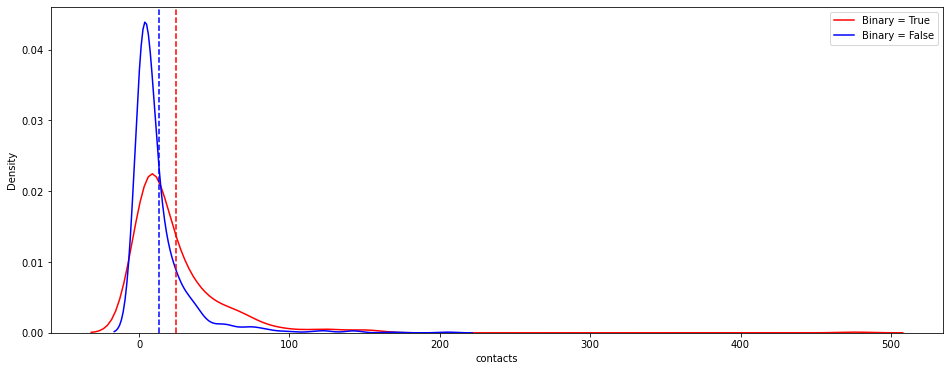

In [ ]:
find_cat_quant_correlation(quant_value = data['contacts'], binary_mask=data['is_selling_2']=='Sold', plot = True, print_inference = False)

### Ищем пороги для прокси-метрики

Чтобы более детально проанализировать связь прокси и целевой метрик рассмотрим динамику их изменения в разрезе градаций перцентилей прокси-метрики. Возьмем децили, т.е. значения перцентилей с шагом 10%.

Посмотрим что получится на примере просмотров:

In [ ]:
# разбиваем исходную количественную величину на квантили с нужным шагом
deciles_bins = np.quantile(data['views'], np.arange(0, 1, 0.1))
deciles_bins

array([   0. ,   83.9,  147. ,  207.7,  296.6,  408. ,  555. ,  751.9,
       1140.2, 2091.3])

In [ ]:
# разбиваем ряд на бины, соответствующие перцентилям выпбранного признака
inds = np.digitize(data['views'], deciles_bins, right = False)
inds

array([ 2,  2,  2, ..., 10, 10, 10])

In [ ]:
# размечаем имеющиеся наблюдения по принадлежности к каждому перцентилю
df = pd.DataFrame({'quant_value': data['views'],
                  'binary': data['is_selling_2']=='Sold',
                  'bins': inds})
df

,quant_value,binary,bins
0,84,False,2
1,95,False,2
2,118,False,2
3,11,False,1
4,48,False,1
...,...,...,...
1195,2477,True,10
1196,469,True,6
1197,2663,True,10
1198,2673,True,10


In [ ]:
# агрегируем по перцентилям и рассчитываем среднее значение просмотров и уровень конверсии в продажу
inference = df.groupby('bins').mean()
inference

,quant_value,binary
bins,,
1,49.475000,0.266667
2,115.245763,0.279661
3,173.040984,0.319672
4,250.250000,0.333333
5,351.341667,0.283333
6,477.436975,0.319328
7,641.173554,0.388430
8,925.291667,0.383333
9,1546.708333,0.366667


### Упакуем поиск оптимальных порогов в функцию с дополнительной отрисовкой графика

Эта функция принимает на вход количественную переменную, бинарную маску и шаг, с которым мы идем по количественной переменной и разбиваем ее на бины (корзины). В рамках этих бинов мы пытаемся найти среднюю конверсию. Например, если мы разбили количественную переменную на квартиль, значит, будет четыре бина: до 25-го квантиля, до 50-го, до 75-го и до 100-го. В каждом из этих бинов мы найдем среднее значение количественной метрики и среднее значение конверсии, долю того, происходила продажа или нет. Функция показывает корреляцию и отрисовывает графики.

In [ ]:
# напишем функцию для визуализации и поиска оптимальных порогов для создания прокси-метрики

def proxy_metrics_bins_analizer(quant_value, binary_mask, step):

    #разбиваем исходную количественную величину на квантили с нужным шагом
    deciles_bins = np.quantile(quant_value, np.arange(0, 1, step))
    #разбиваем ряд на бины
    inds = np.digitize(quant_value, deciles_bins, right = False)
    # агрегируем
    df = pd.DataFrame({'quant_value':quant_value,
                  'binary': binary_mask,
                  'bins': inds})
    inference = df.groupby('bins').mean()

    #считаем point biserial корреляцию
    point_biserial_R = find_cat_quant_correlation(quant_value = quant_value, binary_mask=binary_mask, plot = False, print_inference = False)['point biserial R']

    # рисуем график
    plt.figure(figsize=(12,6))
    sns.lineplot(y = inference['quant_value'], x = inference.index*step, color = 'red', label = 'quant_value')
    plt.axhline(y = quant_value.median(), linestyle = '--', color = 'red')
    plt.text(x = inds.mean()*step, y = np.quantile(quant_value, 0.95), s ='point_biserial_R = {}'.format(point_biserial_R), )
    ax2 = plt.twinx()
    sns.lineplot(y = inference['binary'], x = inference.index*step, color = 'blue', ax=ax2, label = 'binary share')
    plt.axhline(y = binary_mask.mean(), linestyle = '--', color = 'blue')
    plt.legend()

# Проверка кандидатов в прокси-метрики

В качестве кандидатов в прокси-метрики проанализируем следующие метрики:

- views – объем просмотров объявления, который оно набрало в период с момента размещения до момента снятия с публикации


- contacts – объем контактов, которое набрало объявление, сколько раз был показан телефон покупателя и сколько было написано сообщений продавцу от покупателя


- live_days – количество дней, которое объявление было активно


- соотношение contacts/views


- соотношение contacts/live_days


- last_7_contacts – сколько контактов набрало объявление за последние 7 дней до ухода в архив


- last_3_contacts – сколько контактов набрало объявление за последние 3 дня до ухода в архив

### Просмотры (views)

Первый кандидат — это views, суммарный объем просмотров объявления. Кажется, что чем больше объявление набрало просмотров, тем более вероятно, что конверсия в продажу будет выше. Посмотрим, есть ли корреляция между ними.

Посмотрим, есть ли различия в распределении просмотров в зависимости от того, продали ли авто или нет

Mean quant value for group (binary=1) = 1017.3844282238443
Mean quant value for group (binary=0) = 732.106463878327
Median quant value for group (binary=1) = 500.0
Median quant value for group (binary=0) = 368.0
Kruskal-Wallis H Test p-value = 0.00011486887007781793
T-test p-value = 0.00018505614391999982
point biserial correlation = 0.10772185104605951


{'point biserial R': 0.10772185104605951,
 'kruskal_pval': 0.00011486887007781793,
 'ttest_pval': 0.00018505614391999982}

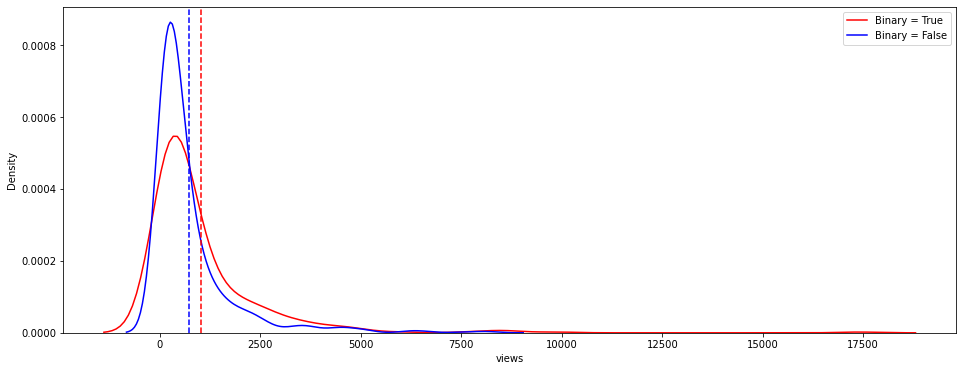

In [ ]:
find_cat_quant_correlation(quant_value = data['views'], binary_mask=data['is_selling_2']=='Sold', plot = True, print_inference = True)

T-тест и критерий Краскела-Уоллиса показывают, что средние между группами явно и не случайно различны. Есть определенная корреляция (0.10772185104605951), но она не самая высокая.

Видим, что распределения и средние явно различаются (стат критерии показывают различия в средних), но корреляция недостаточно высокая.

На графике синее распределение - это просмотры объявлений, у которых не было продажи, а красное - просмотры объявлений с продажей. Действительно, среднее сдвинуто в красном распределении правее, а в синем - больше объявлений с нулевыми просмотрами или близко к нулю.

Рассмотрим функцию для анализа порогов. Передадим этой функции на вход просмотры и бинарную маску по продаже. Также зададим значение 0.1 для параметра step — это будет означать, что мы проводим децильный анализ, то есть разбиваем метрику по децилям.

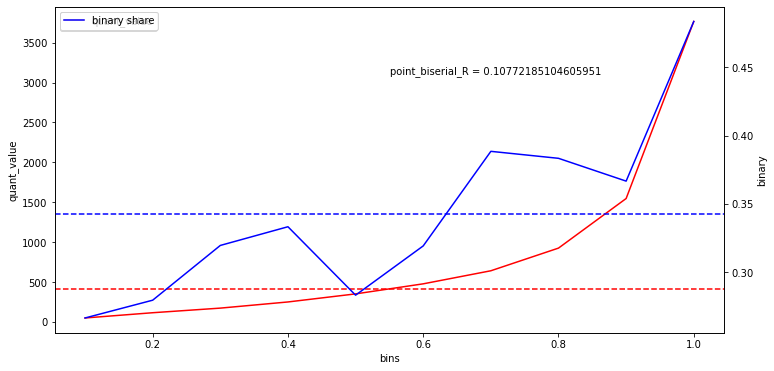

In [ ]:
# step 0.1 означает, что мы разбиваем нашу метрику по децилям
proxy_metrics_bins_analizer(quant_value = data['views'], binary_mask=data['is_selling_2']=='Sold', step = 0.1)

На графике отображены 10 бинов. Красный график показывает среднее значение в группе по количественной метрике. Он растет по децилям вверх. Синий график представляет больший интерес, так как он показывает значение средней конверсии в децильном интервале по количественной метрике. Видно, что с ростом количественной метрики доля конверсии начинает расти: например, для седьмого дециля конверсия близка к значению 0,4, а на третьем дециле она имеет значение 0,32.

Есть скачок конверсии после 0,6 квантиля.

В целом видно, что просмотры отлавливают влияние на рост вероятности продать авто. Но видно, что есть много других факторов, размывающих влияние. Попробуем поискать еще хорошие варианты метрик

### Суммарные контакты (contacts)

Mean quant value for group (binary=1) = 24.284671532846716
Mean quant value for group (binary=0) = 13.135614702154626
Median quant value for group (binary=1) = 12.0
Median quant value for group (binary=0) = 6.0
Kruskal-Wallis H Test p-value = 9.980588061981067e-19
T-test p-value = 1.2166186100304946e-11
point biserial correlation = 0.19401064582973623


{'point biserial R': 0.19401064582973623,
 'kruskal_pval': 9.980588061981067e-19,
 'ttest_pval': 1.2166186100304946e-11}

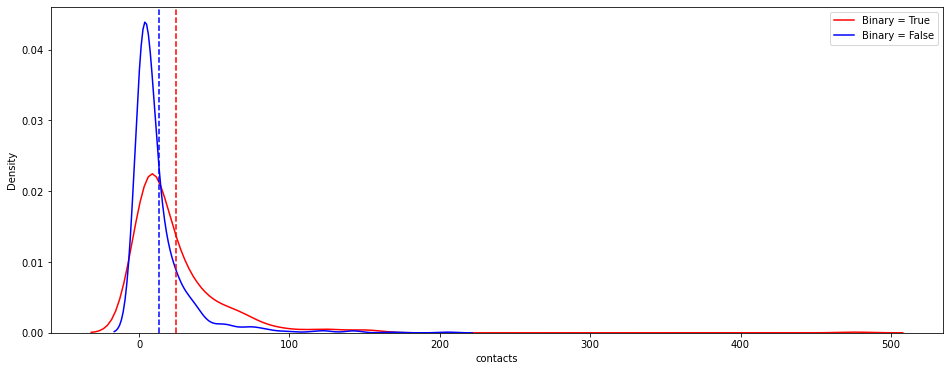

In [ ]:
find_cat_quant_correlation(quant_value = data['contacts'], binary_mask=data['is_selling_2']=='Sold', plot = True, print_inference = True)

Мера различий между группами (p-value в критериях) выглядит более значимой. Так же, как и уровень корреляции. Значит, мы двигаемся в правильном направлении.

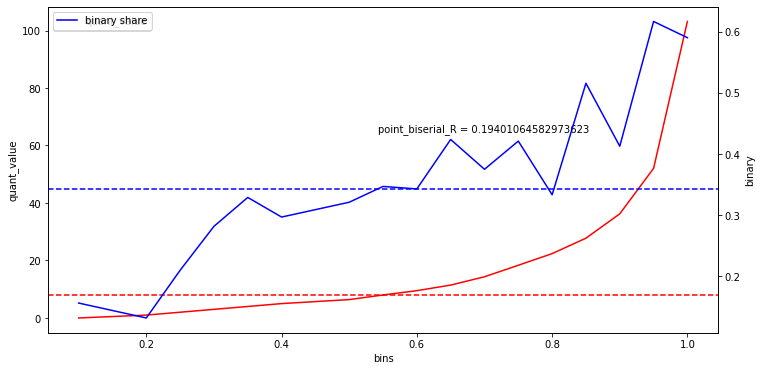

In [ ]:
proxy_metrics_bins_analizer(quant_value = data['contacts'], binary_mask=data['is_selling_2']=='Sold', step = 0.05)

Видно, что между контактами и долей проданных автомобилей есть корреляция

### Логарифм contacts

Mean quant value for group (binary=1) = 2.618697674792375
Mean quant value for group (binary=0) = 1.9687405430469196
Median quant value for group (binary=1) = 2.5649493574615367
Median quant value for group (binary=0) = 1.9459101490553132
Kruskal-Wallis H Test p-value = 9.980588061981067e-19
T-test p-value = 1.2127397196980984e-19
point biserial correlation = 0.25760737743473805


{'point biserial R': 0.25760737743473805,
 'kruskal_pval': 9.980588061981067e-19,
 'ttest_pval': 1.2127397196980984e-19}

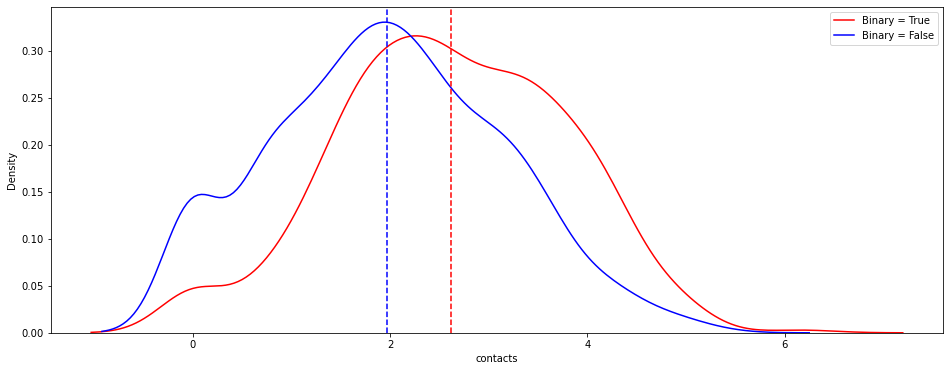

In [ ]:
find_cat_quant_correlation(quant_value = np.log(data['contacts']+1), binary_mask=data['is_selling_2']=='Sold', plot = True, print_inference = True)

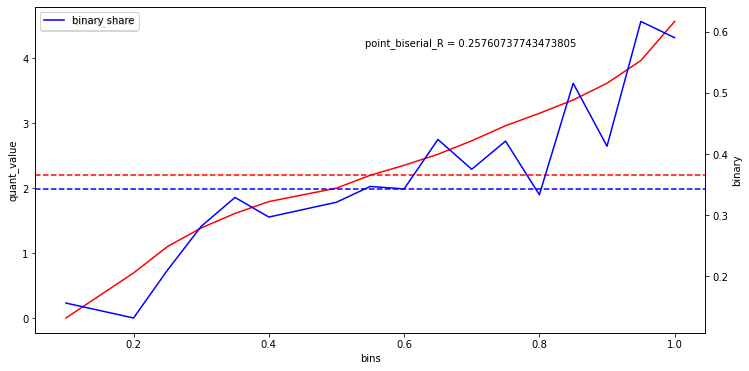

In [ ]:
proxy_metrics_bins_analizer(quant_value = np.log(data['contacts']+1), binary_mask=data['is_selling_2']=='Sold', step = 0.05)

После преобразования метрики контактов корреляция стала видна еще сильнее. То, что логарифм работает на корреляцию лучше, говорит о том, что вероятность сконтактировать прирастает нелинейно от количества контактов.

### Live days

Кажется, что количество проведенных в листинге дней также должно повышать вероятность продажи. Давайте рассмотрим, как эта метрика влияет на вероятность продажи.

Mean quant value for group (binary=1) = 10.150851581508515
Mean quant value for group (binary=0) = 12.724968314321927
Median quant value for group (binary=1) = 8.0
Median quant value for group (binary=0) = 8.0
Kruskal-Wallis H Test p-value = 1.1322319834713854e-14
T-test p-value = 7.710755933111699e-06
point biserial correlation = -0.12872277961206446


{'point biserial R': -0.12872277961206446,
 'kruskal_pval': 1.1322319834713854e-14,
 'ttest_pval': 7.710755933111699e-06}

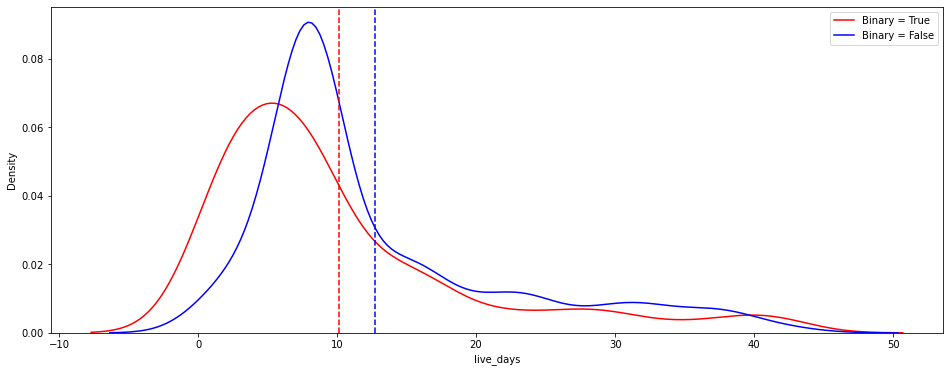

In [ ]:
find_cat_quant_correlation(quant_value = (data['live_days']), binary_mask=data['is_selling_2']=='Sold', plot = True, print_inference = True)

Видно, что длительность пребывания в live влияет на вероятность продать автомобиль. При этом вероятность падает с ростом длительности присутствия в live. Также кажется, что влияние длительности нелинейное, поэтому попробуем преобразовать метрику.

Mean quant value for group (binary=1) = 1.903649116406305
Mean quant value for group (binary=0) = 2.3032503171939456
Median quant value for group (binary=1) = 2.0794415416798357
Median quant value for group (binary=0) = 2.0794415416798357
Kruskal-Wallis H Test p-value = 1.1322319834713854e-14
T-test p-value = 6.349534248658027e-16
point biserial correlation = -0.230413096668318


{'point biserial R': -0.230413096668318,
 'kruskal_pval': 1.1322319834713854e-14,
 'ttest_pval': 6.349534248658027e-16}

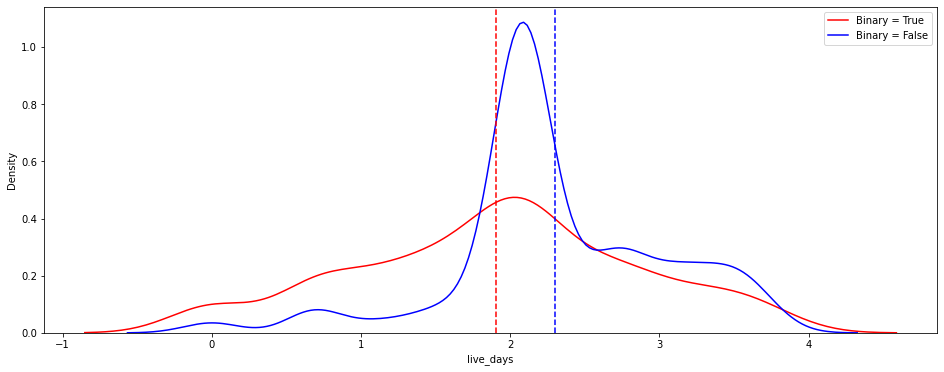

In [ ]:
find_cat_quant_correlation(quant_value = np.log(data['live_days']), binary_mask=data['is_selling_2']=='Sold', plot = True, print_inference = True)

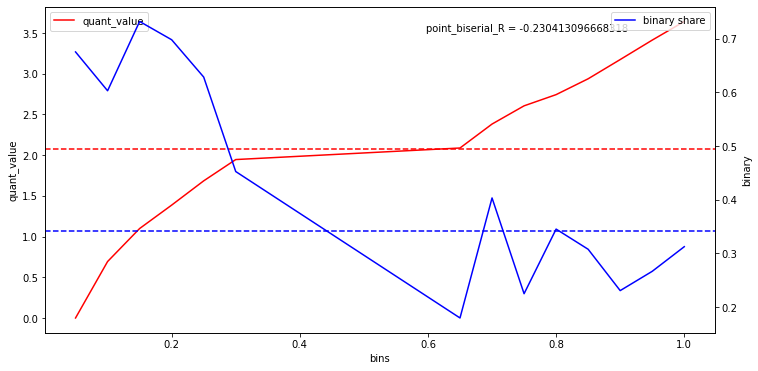

In [ ]:
proxy_metrics_bins_analizer( np.log(data['live_days']), binary_mask=data['is_selling_2']=='Sold', step = 0.05)

Видим, что метрика длительности пребывания в тесте важная для определения вероятности совершения продажи. Но сама по себе все еще несет не достаточно сильную корреляцию.

### Отношение контактов к просмотрам (contacts/views)

Кажется, что хорошим кандидатом на прокси-метрику, предсказывающим вероятность совершения контактов может быть соотношение контактов к просмотрам у объявления. "Хорошее" объявление должно набирать большее кол-во контактов на объем просмотров. Проверим это предположение.

Mean quant value for group (binary=1) = 0.034516588734782555
Mean quant value for group (binary=0) = 0.022656793552670397
Median quant value for group (binary=1) = 0.02557544757033248
Median quant value for group (binary=0) = 0.015267175572519083
Kruskal-Wallis H Test p-value = 2.1088451078274545e-17
T-test p-value = 9.972214444692406e-11
point biserial correlation = 0.18527145231954217


{'point biserial R': 0.18527145231954217,
 'kruskal_pval': 2.1088451078274545e-17,
 'ttest_pval': 9.972214444692406e-11}

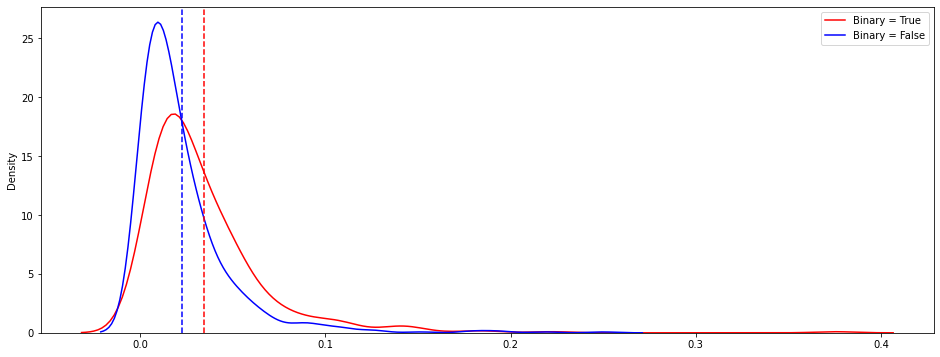

In [ ]:
find_cat_quant_correlation(quant_value = data['contacts'] / (data['views']+1), binary_mask=data['is_selling_2']=='Sold', plot = True, print_inference = True)

C:\Users\kazakov\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


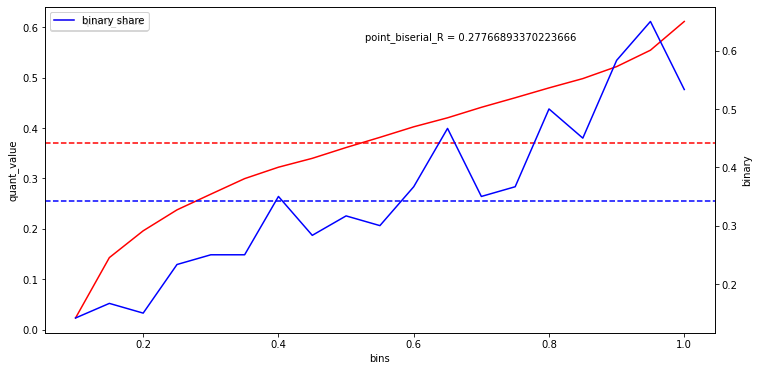

In [ ]:
proxy_metrics_bins_analizer(quant_value = np.log(data['contacts']+1) / np.log(data['views']), binary_mask=data['is_selling_2']=='Sold', step = 0.05)

### Скорость набора контактов (contacts/live_days)

Кажется, что чем быстрее объявление набирает контакты, тем вероятнее произойдет продажа. Проверим это предположение.

Mean quant value for group (binary=1) = 2.785472683880675
Mean quant value for group (binary=0) = 1.1170922804394388
Median quant value for group (binary=1) = 1.6666666666666667
Median quant value for group (binary=0) = 0.6428571428571429
Kruskal-Wallis H Test p-value = 4.811812489816918e-44
T-test p-value = 1.5839426375159415e-35
point biserial correlation = 0.3481797802322052


{'point biserial R': 0.3481797802322052,
 'kruskal_pval': 4.811812489816918e-44,
 'ttest_pval': 1.5839426375159415e-35}

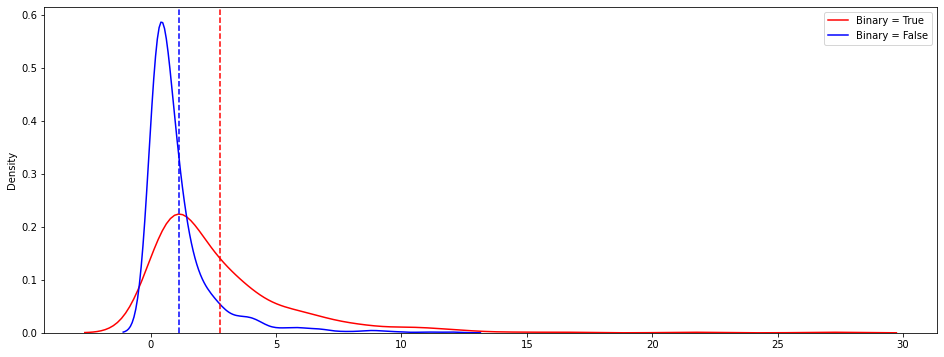

In [ ]:
find_cat_quant_correlation(quant_value = (data['contacts']+1) / (data['live_days']+1), binary_mask=data['is_selling_2']=='Sold', plot = True, print_inference = True)

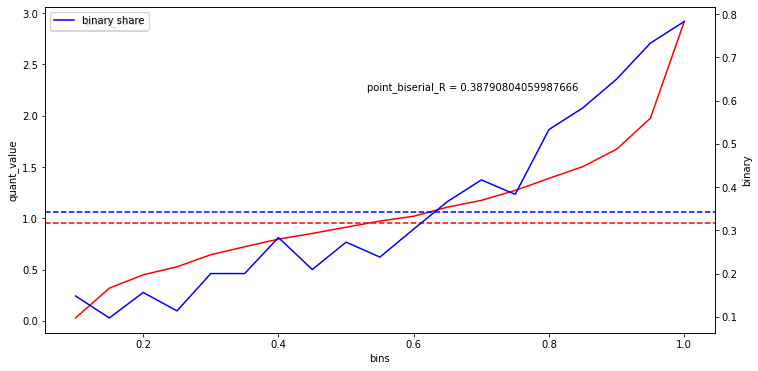

In [ ]:
proxy_metrics_bins_analizer(quant_value = np.log(data['contacts']+1) / np.log(data['live_days']+1), binary_mask=data['is_selling_2']=='Sold', step = 0.05)

### Контакты за последние несколько дней перед уходом в архив (last_7_contacts, last_3_contacts)

Метрика набора контактов за последние три дня сочетает в себе и подсчет контактов, и метрику скорости. Посмотрим, будет ли это хорошим кандидатом на эту роль

Mean quant value for group (binary=1) = 16.124087591240876
Mean quant value for group (binary=0) = 7.108998732572877
Median quant value for group (binary=1) = 10.0
Median quant value for group (binary=0) = 4.0
Kruskal-Wallis H Test p-value = 3.1821541212660747e-29
T-test p-value = 4.1409370143423566e-23
point biserial correlation = 0.2803453016021136


{'point biserial R': 0.2803453016021136,
 'kruskal_pval': 3.1821541212660747e-29,
 'ttest_pval': 4.1409370143423566e-23}

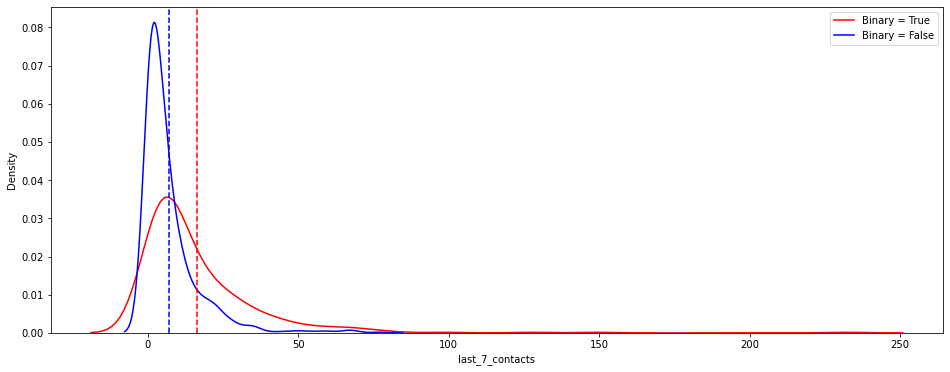

In [ ]:
find_cat_quant_correlation(quant_value = data['last_7_contacts'], binary_mask=data['is_selling_2']=='Sold', plot = True, print_inference = True)

попробуем логарифмировать

Mean quant value for group (binary=1) = 2.3224548692436144
Mean quant value for group (binary=0) = 1.5626914772082992
Median quant value for group (binary=1) = 2.3978952727983707
Median quant value for group (binary=0) = 1.6094379124341003
Kruskal-Wallis H Test p-value = 3.1821541212660747e-29
T-test p-value = 1.7156887701776706e-31
point biserial correlation = 0.3279958353814851


{'point biserial R': 0.3279958353814851,
 'kruskal_pval': 3.1821541212660747e-29,
 'ttest_pval': 1.7156887701776706e-31}

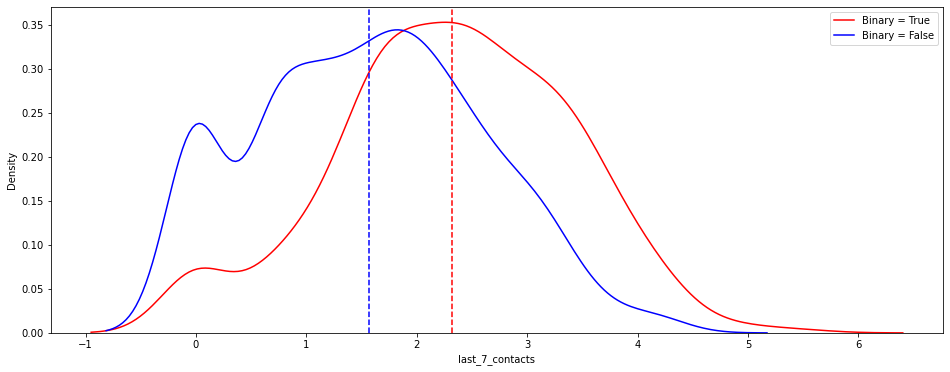

In [ ]:
find_cat_quant_correlation(quant_value = np.log(data['last_7_contacts']+1), binary_mask=data['is_selling_2']=='Sold', plot = True, print_inference = True)

На графике явно видно, что группа, продавшая авто, получала перед уходом в архив больше контактов. И при этом доля тех, кто получил контактов больше 0 у "продавших" значительно ниже

Контакты за последние 3 дня перед уходом в архив.

Посмотрим, как будет вести себя метрика с контактами за 3 дня. Кажется, что, метрика за 3 дня должна еще лучше раскрывать зависимость между фактом продажи и количеством набранных контактов. Сразу прологарифмируем метрику, чтобы сделать ее чуть более линейной.

Mean quant value for group (binary=1) = 1.8937351686159294
Mean quant value for group (binary=0) = 0.9443381111904835
Median quant value for group (binary=1) = 1.9459101490553132
Median quant value for group (binary=0) = 0.6931471805599453
Kruskal-Wallis H Test p-value = 1.1733129557672549e-45
T-test p-value = 6.05383456974365e-52
point biserial correlation = 0.4180024619744417


{'point biserial R': 0.4180024619744417,
 'kruskal_pval': 1.1733129557672549e-45,
 'ttest_pval': 6.05383456974365e-52}

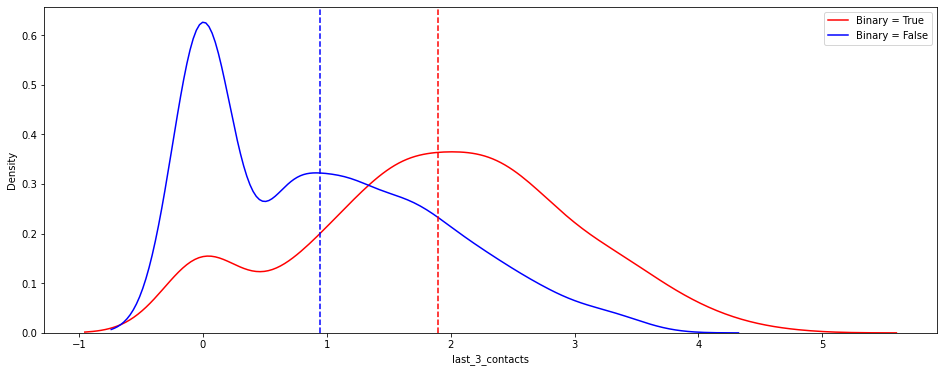

In [ ]:
find_cat_quant_correlation(quant_value = np.log(data['last_3_contacts']+1), binary_mask=data['is_selling_2']=='Sold', plot = True, print_inference = True)

Корреляция пока самая высокая (0.418) среди всех метрик. Видно, что в синей группе очень много объявлений, у которых есть нулевое значение. Это означает, что много объявлений не набрали контактов. А у тех объявлений, которые продались, доля нулевых контактов за 3 дня, значительно ниже. Среднее сдвинуто значительно правее. Посмотрим, как ведет себя прирост конверсии:

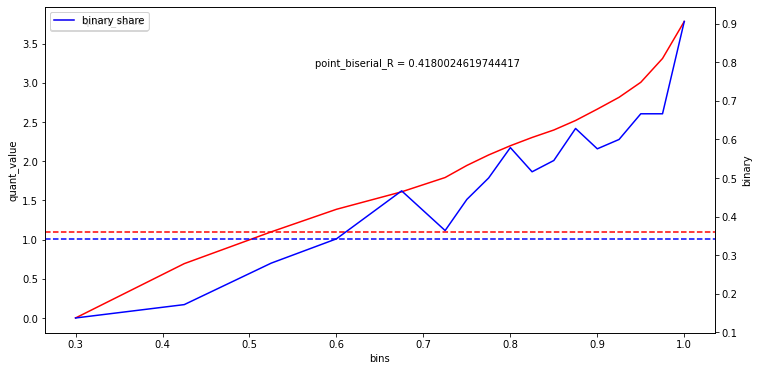

In [ ]:
proxy_metrics_bins_analizer(quant_value = np.log(data['last_3_contacts']+1), binary_mask=data['is_selling_2']=='Sold', step = 0.025)

Мы нашли неплохого кандидата на роль прокси-метрики для факта продажи авто - набранное кол-во контактов за 3 дня перед уходом в архив.

# Перебираем пороги для максимизации корреляции между двумя бинарными метриками

Прирост конверсии достаточно линейный. Конверсия растет по мере роста квантиля количественной метрики. Например, на 0,9 квантиле значение конверсии 0,6, а на 0,5 квантиле значение конверсии 0,25.

Кажется, что мы нашли неплохого кандидата на роль proxy-метрики — то, сколько объявление набирает контактов за три дня до ухода в архив.

Дальше можно идти по двум путям:

1. оставить количественную proxy-метрику, так же смотреть в A/B-тестах, выросло ли среднее контактов за три дня или нет;
2. привести количественную proxy-метрику к доле. Найти какой-то порог и утверждать, что если выросла доля объявлений, которые набрали выше какого-то значения контактов за три дня, значит целевая метрика тоже будет расти. В этом случае proxy-метрика тоже становится бинарной.

Пойдем вторым путем - переведем числовую непрерывную переменную в дискретную (бинарную)

Согласно визуальному анализу стоит начать перебор параметров от медианы и выше, но также необходимо посмотреть и долю пользователей не получавших контакты перед уходом в архив

### Cramer's V

Для оценки ассоциации (корреляции) между двумя бинарными переменными используется **Cramer's V**. Point biserial correlation применяется, когда одна из переменных является бинарной, а другая — вещественной. Если у нас есть вещественная прокси-метрика и бинарный таргет, использование point-biserial будет более логичным. Если обе переменные категориальные, то нужно использовать Cramer's V. Этот критерий основан на подсчете xи-квадрат значения.

Дополнительная информация по Cramer's V

https://towardsdatascience.com/how-strongly-associated-are-your-variables-80493127b3a2

https://medium.com/@manindersingh120996/understanding-categorical-correlations-with-chi-square-test-and-cramers-v-a54fe153b1d6

Воспользуемся формулой Cramer_V со смещением (https://en.wikipedia.org/wiki/Cramér%27s_V)

$$\tilde{V} = \sqrt{\frac{\tilde{\varphi}^2}{min(\tilde{k}-1, \tilde{r}-1)}}$$

где

$\tilde{\varphi}^2 = max\left(0, \varphi^2-\frac{(k-1)(r-1)}{n-1}\right)$

$\tilde{k} = k-\frac{(k-1)^2}{n-1}$

$\tilde{r} = r-\frac{(r-1)^2}{n-1}$

$\varphi^2 = \frac{\chi^2}{n}$, где $\chi^2$ - хи-квадрат Пирсона

$n$ - общее кол-во наблюдений

$k$ - кол-во столбцов (факторов)

$r$ - кол-во строк (групп)

In [ ]:
#создадим функцию для оценки ассоциации двух бинарных переменных
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    cramers_v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    return (cramers_v)

Функция принимает на вход таблицу сопряженности или confusion matrix, где по столбцам и строкам категорийные значения метрик, а в самих ячейках — количество объявлений, которые попадают в значения бинов.

Посмотрим, как работает функция Крамер V на примере расчета корреляции между тем, что объявление продалось или не продалось и тем, что объявление за последние три дня перед уходом в архив набрало больше 4 или не больше 4 контактов.

In [ ]:
pd.crosstab(data['is_selling_2']=='Sold', data['last_3_contacts']>4)

last_3_contacts,False,True
is_selling_2,,
False,610,179
True,176,235


In [ ]:
# для примера давайте рассмотрим корреляцию между следующими метриками
confusion_matrix = pd.crosstab(data['is_selling_2']=='Sold', data['last_3_contacts']>4)
cramers_v(confusion_matrix.values)

0.3413854425014344

Значение равно 0,34. Важно сказать, что это значение изменяется от 0 до 1. Чем ближе к 1, тем ближе степень связи или ассоциации выше. Для того, чтобы идти по порогам и перебирать их значения, напишем небольшую функцию, которая будет упрощать работу:

Прежде, чем найти порог, посмотрим долю бесконтактных объявлений: много ли объявлений, которые не набирают контакты?

In [ ]:
# доля бесконтактных
(data['last_3_contacts']== 0).sum() / len(data)

0.2925

Таких объявлений примерно 29%.

In [ ]:
#попробуем найти порог, при котором коэффициент ассоциации cramer V будет максимальным

def max_cramerv_corr_finder(quant_value, binary_mask, plot = True, print_inference = True, step = 1):
    '''
    quant_value - исходная количественная переменная по которой мы пытаемся найти порог
    binary_mask - бинарная метрика с целевой конверсией к которой мы исщем максимальную корреляцию
    plot - нужно ли рисовать граиф
    print_inference - нужно ли принтовать выводы
    step - размер шага с которым мы идем по quant_value и определяем пороги
    '''
    # определяем вектор исходной количественной переменной, на котором мы будет искать максимальную корреляцию
    arange = np.arange(min(quant_value), max(quant_value), step)
    cramers_v_list = []

    #циклом проходим по всем порогам и находим значение cramers_v
    for i in arange:
        confusion_matrix = pd.crosstab(binary_mask, quant_value>i)
        cramers_v_i = cramers_v(confusion_matrix.values)
        cramers_v_list.append(cramers_v_i)

    # сохраняем максимальные найденные значения корреляции и порога, при котором она достигается
    max_corr_quant_value = arange[np.argmax(np.array(cramers_v_list))]
    max_cramer_v = max(cramers_v_list)

    # отрисовываем график
    if plot:
        sns.lineplot(x = arange, y = cramers_v_list)
        plt.axhline(y = np.array(cramers_v_list).max(), linestyle = '--', color = 'red')
        plt.axvline(x = max_corr_quant_value, linestyle = '--', color = 'red')
        plt.xlabel('quant values')
        plt.ylabel('Cramer-V')

    ## принтуем выводы
    if print_inference:
        print('Maximum Cramer V =', np.array(cramers_v_list).max())
        print('Maximum Cramer V quant value = ', max_corr_quant_value)

    return({'max_cramer_v': max_cramer_v,
           'max_corr_quant_value': max_corr_quant_value})

Функция принимает на вход количественную переменную и бинарную маску, в зависимости от значения True или False параметра print_inference выводит интересные статистические значения, в зависимости от значения True или False параметра plot рисует график а еще есть возможность в параметре step задать шаг, с которым будет происходить перебор значений в количественной переменной. Функция идет по порогам и пытается найти степень ассоциации.

Посмотрим, как эта функция работает с метрикой, показывающей контакты за последние три дня и фактом продажи автомобиля, выведем график и интересные значения, установив шаг в единицу. Сама метрика нелогарифмированная, это означает, что мы будем идти с контактом в шаг 1: 0 контактов за три дня, 1 контакт за три дня, 2 контакта за три дня и так далее.

Maximum Cramer V = 0.3686253838357947
Maximum Cramer V quant value =  3


{'max_cramer_v': 0.3686253838357947, 'max_corr_quant_value': 3}

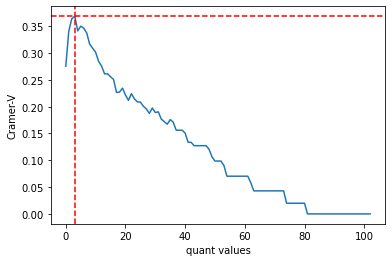

In [ ]:
max_cramerv_corr_finder(data['last_3_contacts'], data['is_selling_2']=='Sold', plot = True, print_inference = True, step = 1)

Maximum Cramer V = 0.3686253838357947
Maximum Cramer V quant value =  1.4000000000000001


{'max_cramer_v': 0.3686253838357947,
 'max_corr_quant_value': 1.4000000000000001}

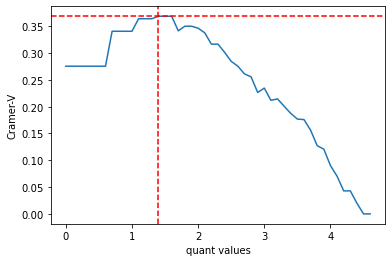

In [ ]:
# давайте попробуем прогнать этот кусочек с логарифмированной метрикой
max_cramerv_corr_finder(np.log(data['last_3_contacts']+1), data['is_selling_2']=='Sold', plot = True, print_inference = True, step = 0.1)

Лучший Крамер V равен значению 0.3686253838357947 — это степень ассоциации между бинарными переменными. Лучшее количественное значение соответствует трём контактам. Это лучший трешхолд. После значения равного числу 3 Крамер V падает и по графику видно, что нет смысла делать порог, например, равный числу 60, потому что на этом пороге значение ассоциации близко к нулю. Но при этом, пороговое значение не нужно делать и нулевым: степень ассоциации здесь хоть и выше, чем у большинства значений, но не максимальное.

Попробуем использовать логарифмированную метрику. В этом случае значением для параметра step следует выбрать не число 1, потому что логарифмированное значение будет доходить до 4 из-за малой гранулярности. Установим число 0,1.

In [ ]:
# преобразуем в исходную шкалу полученное рекомендованное значение
np.exp(1.4)-1

3.0551999668446745

Максимальное прологарифмированое значение это 1.4. Если трансформировать значение обратно, получим число 3,0551999… — те же самые 3 контакта.

Так мы определили порог, при котором достигается наилучшая степень ассоциации между двумя бинарными метриками.

Итак мы нашли, что по историческим данным наилучшая корреляция достигается при 3+ уровне контактов за 3 дня перед отправкой в архив

# Проверим чувствительность прокси-метрики на симуляциях по историческим данным

Проверка через А/Б-тест заключается в том, сможем ли мы находить реальные изменения в целевой метрике, наблюдая изменения в прокси-метрике.
Для этого необходим реально проведенный А/Б-тест, где есть найденное изменение в целевой метрике.
Либо, где эффекта в целевой метрике нет, и мы смотрим, как часто наша прокси метрика говорит, что эффект все-таки есть.

Помимо поиска корреляции, также необходимо находить еще и причинно-следственную связь. Все, что найдено на данный момент — это только высоко коррелированная метрика и пока нет уверенности в том, что она говорит о причинно-следственной связи, что, если действительно вырастет доля объявлений, которые набирают 3 контакта и выше, то вырастет и доля объявлений с проданными автомобилями и мы сможем эту метрику использовать в A/B-тесте. Это можно проверять разными способами, например, casual-inference методиками, либо A/B-тестом.

Для начала проведем симуляции: возьмем имеющиеся исторические данные и будем каждый раз их разбивать на условные A и B группы, как будто бы у нас есть разбиение на A и B группы с платформы A/B-тестов. Имея это разбиение, мы будем пытаться назвать значение конверсии в продажу для контрольной и тестовой группы. Затем рассчитаем нужные значения для статистического критерия — количество наблюдений в группах A и B и количество случаев, в которых отслеживаемая метрика равна единице. Для этого мы задаемся вопросом: «В нашей бинарной маске по тем, кто продался сколько тех, кто продался в группе A и сколько в группе B?» Если представить, что это подбрасывание монетки, то можно представить это в виде вопроса «Сколько орлов в группе А и сколько орлов в группе B?» И то же самое для количественной метрики: «Сколько объявлений, у которых контактов за последние три дня больше, чем пороговое значение?» Эти расчеты нужны для того, чтобы сделать тест на пропорцию, на долю. Чаще всего для этого используется z-тест, когда требуется проверить равенство долей в двух выборках. Код ниже дает ответ на вопрос, будет ли подобный тест на proxy-метрике или на целевой метрике выдерживать нужные значения уровня статистической значимости или же не будет

### А/А-симуляция для оценки точности

In [ ]:
#AA test simulation on target metric
# проведем симуляцию оценки равенства долей двумя способами. Непосредственно оценку доли проданных
# и оценку тех, кто набрал 3+ контактов за период до ухода в архив

aa_binary_ztest_pvalue_list = []
aa_quant_ztest_pvalue_list = []
quant_target_level = 3
n_sim = 1000

for i in range(1000):
    sample_mask = ss.bernoulli.rvs(0.5, size=len(data)) == 1

    binary_mask_group_a = (data['is_selling_2']=='Sold')[sample_mask]
    binary_mask_group_b = (data['is_selling_2']=='Sold')[~sample_mask]
    quant_value_group_a = (data['last_3_contacts'])[sample_mask]
    quant_value_group_b = (data['last_3_contacts'])[~sample_mask]

    binary_nobs_group_a = len(binary_mask_group_a)
    binary_nobs_group_b = len(binary_mask_group_b)
    quant_nobs_group_a = len(quant_value_group_a)
    quant_nobs_group_b = len(quant_value_group_b)

    binary_counts_group_a = binary_mask_group_a.sum()
    binary_counts_group_b = binary_mask_group_b.sum()
    quant_counts_group_a = (quant_value_group_a >= quant_target_level).sum()
    quant_counts_group_b = (quant_value_group_b >= quant_target_level).sum()

    #проведем z-test для оценки равенства долей в двух группах
    binary_z_score_i, binary_ztest_pvalue_i = sms.proportions_ztest(count = [binary_counts_group_a, binary_counts_group_b],
                          nobs = [binary_nobs_group_a, binary_nobs_group_b])

    quant_z_score_i, quant_ztest_pvalue_i = sms.proportions_ztest(count = [quant_counts_group_a, quant_counts_group_b],
                          nobs = [quant_nobs_group_a, quant_nobs_group_b])

    aa_binary_ztest_pvalue_list.append(binary_ztest_pvalue_i)
    aa_quant_ztest_pvalue_list.append(quant_ztest_pvalue_i)

binary_alpha_ci = proportion_confint((np.array(aa_binary_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)
quant_alpha_ci = proportion_confint((np.array(aa_quant_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)

print('Количество случаев ложного прокраса теста при оценке доли продавших:', (np.array(aa_binary_ztest_pvalue_list) <= 0.05).sum())
print('Уровень статистической значимости оценки (доля продавших):', (np.array(aa_binary_ztest_pvalue_list) <= 0.05).sum()/n_sim)
print('99%-процентный доверительный интервал для уровня стат. значимости для целевой метрики (доля продавших)', binary_alpha_ci)
print('------------------')
print('Количество случаев ложного прокраса теста при оценке доли тех, кто набрал 3= контакта за 3 дня:',(np.array(aa_quant_ztest_pvalue_list) <= 0.05).sum())
print('Уровень статистической значимости оценки (доля набравших 3+):', (np.array(aa_quant_ztest_pvalue_list) <= 0.05).sum()/n_sim)
print('99%-процентный доверительный интервал для уровня стат. значимости для прокси метрики (доля продавших)', quant_alpha_ci)

Количество случаев ложного прокраса теста при оценке доли продавших: 50
Уровень статистической значимости оценки (доля продавших): 0.05
99%-процентный доверительный интервал для уровня стат. значимости для целевой метрики (доля продавших) (0.03224732165140968, 0.06775267834859033)
------------------
Количество случаев ложного прокраса теста при оценке доли тех, кто набрал 3= контакта за 3 дня: 52
Уровень статистической значимости оценки (доля набравших 3+): 0.052
99%-процентный доверительный интервал для уровня стат. значимости для прокси метрики (доля продавших) (0.033914816482989676, 0.07008518351701032)


В конце происходит подсчет значений p-value, они помещаются в список, который был задан в начале. Происходит поиск значений alpha для 1000 симуляций и доверительный интервал для alpha целевой метрики и для alpha proxy-метрики. После запуска кода видим следующие результаты: в доле продаж, нашей целевой метрике, уровень alpha выдерживается. Доверительный интервал для 1000 попыток таких испытаний — значения от 0.03 до 0.07. Это говорит о том, что proxy-метрику можно использовать так же, как и целевую метрику, потому что она помогает выдерживать уровень alpha.

### А/B-симуляции для оценки мощности

Часто бывает интересно не сколько выдерживается уровень alpha, а выдерживается ли мощность теста? Действительно ли при использовании proxy-метрики мощность не будет сильно ниже, чем при использовании целевой метрики? Для проверки мощности код будет тот же самый, однако, стоит сказать, что, поскольку это A/B-симуляция, необходимо добавить эффект определенного размера в тестовую группу следующим образом:

In [ ]:
#AB test simulation

ab_binary_ztest_pvalue_list = []
ab_quant_ztest_pvalue_list = []
quant_target_level = 3
abs_effect = 0.1
n_sim = 1000

for i in range(n_sim):
    sample_mask = ss.bernoulli.rvs(0.5, size=len(data)) == 1

    binary_mask_group_a = (data['is_selling_2']=='Sold')[sample_mask]
    binary_mask_group_b = (data['is_selling_2']=='Sold')[~sample_mask]
    quant_value_group_a = (data['last_3_contacts'])[sample_mask]
    quant_value_group_b = (data['last_3_contacts'])[~sample_mask]

    binary_nobs_group_a = len(binary_mask_group_a)
    binary_nobs_group_b = len(binary_mask_group_b)
    quant_nobs_group_a = len(quant_value_group_a)
    quant_nobs_group_b = len(quant_value_group_b)

    binary_counts_group_a = binary_mask_group_a.sum()
    binary_counts_group_b = round(binary_mask_group_b.sum()*(1+abs_effect)) #add effect
    quant_counts_group_a = (quant_value_group_a >= quant_target_level).sum()
    quant_counts_group_b = round((quant_value_group_b >= quant_target_level).sum()*(1+abs_effect)) #add effect

    binary_z_score_i, binary_ztest_pvalue_i = sms.proportions_ztest(count = [binary_counts_group_a, binary_counts_group_b],
                          nobs = [binary_nobs_group_a, binary_nobs_group_b])

    quant_z_score_i, quant_ztest_pvalue_i = sms.proportions_ztest(count = [quant_counts_group_a, quant_counts_group_b],
                          nobs = [quant_nobs_group_a, quant_nobs_group_b])

    ab_binary_ztest_pvalue_list.append(binary_ztest_pvalue_i)
    ab_quant_ztest_pvalue_list.append(quant_ztest_pvalue_i)

binary_power_ci = proportion_confint((np.array(ab_binary_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)
quant_power_ci = proportion_confint((np.array(ab_quant_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)

print('Effect =', abs_effect)
print('Sample size A group =', binary_nobs_group_a)
print('Sample size B group =', binary_nobs_group_b)

print('Target conversion A group = ', binary_counts_group_a / binary_nobs_group_a)
print('Target conversion B group = ', binary_counts_group_b / binary_nobs_group_b)
print('Proxy conversion A group = ', quant_counts_group_a / quant_nobs_group_a)
print('Proxy conversion B group = ', quant_counts_group_b / quant_nobs_group_b)



print('Мощность АБ-теста по целевой метрике', (np.array(ab_binary_ztest_pvalue_list) <= 0.05).sum() / n_sim)
print('99%-процентный доверительный интервал для мощности (доля продавших)', binary_alpha_ci)


print('Мощность АБ-теста по прокси метрике', (np.array(ab_quant_ztest_pvalue_list) <= 0.05).sum() / n_sim)

Effect = 0.1
Sample size A group = 599
Sample size B group = 601
Target conversion A group =  0.3555926544240401
Target conversion B group =  0.3627287853577371
Proxy conversion A group =  0.4974958263772955
Proxy conversion B group =  0.5158069883527454
Мощность АБ-теста по целевой метрике 0.229
99%-процентный доверительный интервал для мощности (доля продавших) (0.03224732165140968, 0.06775267834859033)
Мощность АБ-теста по прокси метрике 0.37


Как мы видим, мощность теста по прокси-метрике немного выше, чем по основной. Связано это с различем в долях. Доля пользователей с кол-вом контактов больше или равно трех выше, чем тех, кто продал авто. Это разница влияет на то, какое кол-во пользователей нам необходимо, чтобы задетектить ожидаемый размер эффекта.
Поэтому на ограниченной выборке мы можем задетектить.

Прежде всего будут важны такие значения, как мощность A/B-теста по целевой метрики и 99-процентный доверительный интервал для мощности. В целом, картина хорошая, которая и характерна для proxy-метрики: в proxy-метриках мощность даже выше. На данных по 1200 наблюдениям, если бы происходило использование не proxy-метрики, а целевой метрики, то 10-процентный эффект был бы обнаружен правильно даже в большем количестве случаев. Мощность выросла почти на 14 процентов потому что, как правило, proxy-метрики имеют более высокие значения долей и для них нужна меньшая выборка, чтобы обнаруживать эффект.

Проверка на исторических данных proxy-метрики завершена и есть понимание, что эту proxy-метрику можно использовать в z-тесте для определения того, стало ли лучше или нет. Это была проверка на исторических данных. Далее нам будут нужны реальные данные.

### Проверим, как ведет себя прокси метрика на реальном А/В-тесте

Мы решили использовать метрику "кол-во контактов за 3 дня до ухода в архив" как прокси-метрику для конверсии в продажу авто. По симуляциям метрика выглядела неплохо.

Был проведен A/B-тест: было влияние на приложение, по результатам которого нужно понять, стала ли после введенного изменения на сайте выше доля тех объявлений, которые продаются. В качестве контроля за прокси-метрикой был проведен дополнительный обзвон пользователей, ушедших в архив, чтобы определить, продали ли они автомобиль на самом деле. И вместе с этим отслеживалось, стала ли доля тех объявлений, которые набрали 3 и больше контакта выше в тестовой группе. Так мы сможем понять, действительно ли выбранная proxy-метрика помогает отвечать на вопросы о том, стала ли целевая метрика выше через proxy-метрику.

Это позволит нам узнать истинный эффект от нововедения на долю продаваемых и эффект на набор контактов в последние 3 дня перед архивом.
Сопоставив эти два результата, мы поймем позволяет ли прокси-метрика находить эффекты на долю проданных авто.

Данные уже получены и сохранены в файл, поэтому просто загрузим их. Переменные те же самые, но датасет содержит признак разделения на тестовую и контрольную группы (AB_test_group, 1- тестовая, 0 - контрольная)

In [ ]:
ab_test_data = pd.read_csv('proxy_metrics_case_abtest.csv')

In [ ]:
ab_test_data.head()

,views,contacts,last_7_views,last_3_views,last_7_contacts,last_3_contacts,live_days,max_messages_events,messages_events,messages_users,avg_contacts_delta,max_contacts_delta,min_contacts_delta,mumur_advertid,AB_test_group,is_selling_3
0,72,0,19,7,0,0,15,1,1,1,0.00,0,0,1228156847,0,0
1,2040,20,252,87,6,5,27,2,14,12,0.00,0,0,1111412596,1,1
2,4105,56,757,223,10,3,39,3,19,17,0.00,0,0,2292183779,1,0
3,4568,39,854,236,7,3,41,3,29,23,-0.17,2,-2,772897149,1,1
4,56,3,56,10,3,4,7,0,0,0,0.00,2,-1,1598865363,1,1


In [ ]:
# посмотрим есть ли различия в доле продающих пользователей между двумя группами
print((ab_test_data['is_selling_3'][ab_test_data['AB_test_group']==1]).mean())
print((ab_test_data['is_selling_3'][ab_test_data['AB_test_group']==0]).mean())

0.3665997993981946
0.33732136922565636


Можно увидеть, что в группе, в которой были изменения в A/B-тесте, почти на 3 процента конверсия в продажу выросла. Посмотрим, как выглядит proxy-метрика: есть ли различия в доле набравших 3 контакта между двумя группами:

In [ ]:
# посмотрим есть ли различия в доле пользователей, набравших больше 3 контактов между двумя группами
print((ab_test_data['last_3_contacts'][ab_test_data['AB_test_group']==1] > 3).mean())
print((ab_test_data['last_3_contacts'][ab_test_data['AB_test_group']==0] > 3).mean())

0.4745904379806085
0.4230641409106015


Действительно, здесь тоже есть различия: для группы, в которой были изменения доля тех, кто набрал больше 3 контактов составляет почти 47,5 процентов, а для тех, у кого изменений не было в контрольной группе оно всего 42 процента.

Это говорит о том, что proxy-метрика ведет себя сонаправленно с целевой метрикой.

Здесь пока мы не говорили о p-value и статистической значимости. Нам надо сделать статистический вывод. Нужно заметить, что при таком способе проверки, когда, например, есть обзвон, не всегда есть возможность гарантировать нужный объем выборки, чтобы обеспечить нужный уровень alpha и мощность для соответствующего MDE, поэтому, возможно, в нашем случае мощность будет не 0.8.

Проведем тест для целевой метрики и посмотрим, какое значение будет у p-value:

Даже беглый взгляд говорит, что мы можем детектить эффект и через прокси метрику. Давайте посмотрим, что скажут стат критерии.

In [ ]:
# АБ-тест доли продавших
binary_counts_group_a = (ab_test_data['is_selling_3'][ab_test_data['AB_test_group']==0]).sum()
binary_counts_group_b = (ab_test_data['is_selling_3'][ab_test_data['AB_test_group']==1]).sum()

binary_nobs_group_a = len(ab_test_data[ab_test_data['AB_test_group']==0])
binary_nobs_group_b = len(ab_test_data[ab_test_data['AB_test_group']==1])

binary_z_score, binary_ztest_pvalue = sms.proportions_ztest(count = [binary_counts_group_a, binary_counts_group_b],
                          nobs = [binary_nobs_group_a, binary_nobs_group_b])

print('Proportion abs uplift:', (binary_counts_group_b/binary_nobs_group_b) - (binary_counts_group_a/binary_nobs_group_a))
print('Proportion rel uplift:', (binary_counts_group_b/binary_nobs_group_b)/(binary_counts_group_a/binary_nobs_group_a) - 1)
print('Z-test p-value:', binary_ztest_pvalue)

Proportion abs uplift: 0.029278430172538228
Proportion rel uplift: 0.08679684373316987
Z-test p-value: 0.0007852964424626157


Можно заметить абсолютный эффект между конверсиями, его значение (0,029) составляет почти 3 процента. Если считать это значение относительно (0,086), то это почти 9% прироста. P-value низкое (0,0007), что говорит о том, что такие различия в долях не случайны.

Посмотрим такой же A/B-тест, но уже для доли набравших 3 и более контактов:

In [ ]:
# АБ-тест доли набравших 3+
quant_counts_group_a = (ab_test_data['last_3_contacts'][ab_test_data['AB_test_group']==0] > 3).sum()
quant_counts_group_b = (ab_test_data['last_3_contacts'][ab_test_data['AB_test_group']==1] > 3).sum()

quant_nobs_group_a = len(ab_test_data[ab_test_data['AB_test_group']==0])
quant_nobs_group_b = len(ab_test_data[ab_test_data['AB_test_group']==1])

quant_z_score, quant_ztest_pvalue = sms.proportions_ztest(count = [quant_counts_group_a, quant_counts_group_b],
                          nobs = [quant_nobs_group_a, quant_nobs_group_b])

print('Proportion abs uplift:', (quant_counts_group_b/quant_nobs_group_b) - (quant_counts_group_a/quant_nobs_group_a))
print('Proportion rel uplift:', (quant_counts_group_b/quant_nobs_group_b)/(quant_counts_group_a/quant_nobs_group_a) - 1)
print('Z-test p-value:', quant_ztest_pvalue)

Proportion abs uplift: 0.051526297070007
Proportion rel uplift: 0.12179310909949015
Z-test p-value: 1.3926986115308757e-08


Здесь прирост еще более высокий и составляет 5 процентов, а относительный uplift - 12 процентов. Это говорит о том, что proxy-метрика даже сильнее реагирует на нововведения и мы видим, что она дает тот же ответ, что и целевая метрика. Значит в следующих тестах, когда у нас уже не будет обзвонов, мы вполне сможем использовать proxy-метрику для того, чтобы утверждать, поможет ли нам этот A/B-тест или нововведение растить долю продающих объявлений на сайте.

Также стоит сказать, что еще существует закон Гудхарта и, например, через полгода данная proxy-метрика может перестать быть хорошей proxy-метрикой, поэтому важно периодически проводить корреляционный анализ и проверять, не испортилась ли она. Но теоретически сейчас было доказано, что proxy-метрика набора трех контактов и больше дает тот же ответ, что и целевая метрика и ее можно использовать

Как мы видим в обоих метриках есть изменения в доле. Это говорит о том, что мы можем использовать  данную прокси-метрику для того, чтобы находить эффекты в целевой метрике.

# Задача II. СПЕЦИФИКАЦИЯ

По аналогии с задачей поиска прокси-метрики для продажи авто листером команде классифайда нужно найти прокси-метрику, хорошо коррелированную с покупкой авто искателем. Прокси-метрика нужна по тем же причинам, что и у листеров – чтобы точно знать долю искателей авто, которые закрыли через нас потребность.

Регулярно проводить такие опросы в команде не получится, но следить за эффективностью покупок авто через наш классифайд все равно нужно. Для этого команда классифайда провела обзвон наших искателей на предмет того, купили они в итоге авто с помощью классифайда или нет (поле: is_bought). Команда обзванивала пользователей, которые были активны в поиске объявлений, но ушли в отток (не было активности больше семи дней). При этом у пользователей не должно было быть активных объявлений за последние три месяца (для того, чтобы исключить листеров из обзвона).

Алгоритм для работы с прокси-метриками тот же, что и в первой задаче, но основные  кандидаты на прокси-метрику уже получены, нам требуется проделать дальнейшие шаги:

1. провести корреляционный анализ;
2. доработать первичный список;
3. проверить мощность и уровень значимости теста;
4. проверить на реальном А/Б-тесте, позволяет ли прокси-метрика детектить
5. изменение целевой метрики. Анализ чувствительности прокси-метрики.

# Описание данных

Данные уже собраны и загружены в файл proxy_metrics_buyers.csv

Команда достала определенные метрики, которые могут быть полезны для поиска прокси-метрики:

- user_id id пользователя;

- views суммарное количество просмотров объявлений за весь период активности в классифайде на момент ухода искателя в отток;

- contacts суммарное количество контактов по объявлениям (просмотры телефона и написанные сообщения) за весь период активности в классифайде на момент ухода в отток;

- last_7_views просмотры за 7 дней до ухода в отток;

- last_3_views просмотры за 3 дня до ухода в отток;

- last_7_contacts контакты за 7 дней до ухода в отток;

- last_3_contacts контакты за 3 дня до ухода в отток;

- live_days длительность в днях с первого момента появления в продукте до ухода в отток;

- messages_events количество написанных сообщений искателем;

- add_to_favor_events количество добавленных объявлений в избранное;

- max_views_delta разница между самым малоактивным в просмотрах днем (но не нулевым) и самым активным днем в просмотрах.

In [ ]:
data = pd.read_csv('proxy_metrics_buyers.csv')
data

,user_id,views,contacts,last_7_views,last_3_views,last_7_contacts,last_3_contacts,live_days,messages_events,max_views_delta,add_to_favor_events,is_bought
0,151042503,84,2,84,39,2,2,8,0,6,0.0,0
1,151212422,95,0,95,36,0,0,8,0,7,0.0,0
2,151206815,118,3,118,40,3,2,8,0,2,0.0,0
3,151284254,11,0,11,2,0,0,7,0,8,0.0,0
4,151088604,48,2,48,8,2,0,8,0,1,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1188,142367169,2477,34,319,184,4,2,42,42,0,3.0,1
1189,149003341,469,15,231,168,8,8,41,9,1,0.0,1
1190,150878368,2663,23,2112,1213,23,17,10,24,0,0.0,1
1191,149351655,2673,39,1202,528,20,8,24,26,31,1.0,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1193 entries, 0 to 1192
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              1193 non-null   int64  
 1   views                1193 non-null   int64  
 2   contacts             1193 non-null   int64  
 3   last_7_views         1193 non-null   int64  
 4   last_3_views         1193 non-null   int64  
 5   last_7_contacts      1193 non-null   int64  
 6   last_3_contacts      1193 non-null   int64  
 7   live_days            1193 non-null   int64  
 8   messages_events      1193 non-null   int64  
 9   max_views_delta      1193 non-null   int64  
 10  add_to_favor_events  1193 non-null   float64
 11  is_bought            1193 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 112.0 KB


In [ ]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
user_id,1193.0,1.495692e+08,4.548292e+06,102361918.0,150274185.0,151028658.0,151246197.0,151701349.0
views,1193.0,8.294283e+02,1.257705e+03,0.0,173.0,409.0,909.0,17394.0
contacts,1193.0,1.683990e+01,2.706595e+01,0.0,3.0,8.0,21.0,476.0
last_7_views,1193.0,4.281165e+02,5.280135e+02,0.0,137.0,260.0,528.0,7407.0
last_3_views,1193.0,2.055147e+02,3.009814e+02,0.0,43.0,103.0,229.0,2462.0
last_7_contacts,1193.0,1.013998e+01,1.519939e+01,0.0,2.0,5.0,12.0,232.0
last_3_contacts,1193.0,5.585080e+00,9.229894e+00,0.0,0.0,2.0,7.0,103.0
live_days,1193.0,1.187091e+01,9.503360e+00,1.0,7.0,8.0,15.0,43.0
messages_events,1193.0,1.361609e+01,2.082901e+01,0.0,2.0,7.0,16.0,287.0
max_views_delta,1193.0,2.305616e+01,5.832801e+01,-10.0,1.0,4.0,12.0,515.0


# EDA

In [ ]:
# Посмотрим среднюю конверсию в покупку авто
data['is_bought'].value_counts(normalize = True)

is_bought
0    0.659681
1    0.340319
Name: proportion, dtype: float64

In [ ]:
# Посмотрим среднее количество контактов за весь период у тех, кто купил и не купил авто в итоге
data.groupby('is_bought', as_index=False).agg({'contacts':'mean'})

,is_bought,contacts
0,0,12.978399
1,1,24.325123


In [ ]:
# Посмотрим среднее количество добавлений в избранное (add_to_favor_events) для тех, кто купил авто и тех и кто не купил
data.groupby('is_bought', as_index=False).agg({'add_to_favor_events':'mean'})

,is_bought,add_to_favor_events
0,0,0.158831
1,1,0.322660


In [ ]:
# Посмотрим долю пользователей, кто не совершил ни одного контакта для каждой из двух сегментов (тех, кто купил авто и тех, кто не купил авто)
data.assign(has_contacts = lambda x: (x.contacts>0)*1).pivot_table(index='is_bought', columns='has_contacts', values='user_id', aggfunc=pd.Series.nunique)

has_contacts,0,1
is_bought,,
0,81,706
1,15,391


In [ ]:
print('Доля бесконтактных искателей среди тех, кто не купил авто:', round(((data['contacts']==0)[data['is_bought']==0]).mean(), 3))
print('Доля бесконтактных искателей среди тех, кто купил авто:', round(((data['contacts']==0)[data['is_bought']==1]).mean(), 3))

Доля бесконтактных искателей среди тех, кто не купил авто: 0.103
Доля бесконтактных искателей среди тех, кто купил авто: 0.037


In [ ]:
# Посмотрим средний LT (длительность от первого дня до ухода в отток) для двух сегментов.
data.groupby('is_bought', as_index=False).agg({'live_days':'mean'})

,is_bought,live_days
0,0,12.722999
1,1,10.219212


In [ ]:
print('LT искателей среди тех, кто не купил авто:', round(((data['live_days'])[data['is_bought']==0]).mean(), 3))
print('LT искателей среди тех, кто купил авто:', round(((data['live_days'])[data['is_bought']==1]).mean(), 3))

LT искателей среди тех, кто не купил авто: 12.723
LT искателей среди тех, кто купил авто: 10.219


In [ ]:
# посмотрим на отношение между просмотрами и контактами для двух сегментов
data.assign(rate_contacts = lambda x: x.contacts/x.views).groupby('is_bought', as_index=False).agg({'contacts':'mean','views':'mean', 'rate_contacts':'mean'})

,is_bought,contacts,views,rate_contacts
0,0,12.978399,730.429479,0.022825
1,1,24.325123,1021.330049,0.034210


In [ ]:
print('Соотношение контактов к просмотрам в когорте не купивших авто', round((data['contacts'][data['is_bought']==0] / data['views'][data['is_bought']==0]).mean(), 3))
print('Соотношение контактов к просмотрам в когорте купивших авто', round((data['contacts'][data['is_bought']==1] / data['views'][data['is_bought']==1]).mean(), 3))

Соотношение контактов к просмотрам в когорте не купивших авто 0.023
Соотношение контактов к просмотрам в когорте купивших авто 0.034


# Поиск корреляции

In [ ]:
pointbiserialr_lst = []
kruskal_lst = []
ttest_lst = []
for col in data.columns[1:]:
    res = find_cat_quant_correlation(quant_value = data[col], binary_mask=data['is_bought']==1, plot = False, print_inference = False)
    pointbiserialr_lst.append(res['point biserial R'])
    kruskal_lst.append(res['kruskal_pval'])
    ttest_lst.append(res['ttest_pval'])

pd.DataFrame({'features':data.columns[1:], 'pointbiserialr':pointbiserialr_lst, 'kruskal':kruskal_lst, 'ttest':ttest_lst}).sort_values('pointbiserialr', ascending=False).reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,features,pointbiserialr,kruskal,ttest
0,is_bought,1.000000,3.341390e-261,0.000000e+00
1,last_3_contacts,0.363262,2.221558e-45,1.592043e-38
2,last_3_views,0.311280,1.766745e-35,3.231466e-28
3,last_7_contacts,0.284834,2.187389e-29,1.054346e-23
4,last_7_views,0.208163,8.991524e-13,3.811776e-13
5,contacts,0.198719,5.543070e-19,4.338095e-12
6,max_views_delta,0.160610,9.310520e-01,2.434716e-08
7,views,0.109637,5.306506e-05,1.480471e-04
8,messages_events,0.086318,1.466459e-06,2.846538e-03
9,add_to_favor_events,0.063673,3.566563e-18,2.786382e-02


Метрики, у которых самая высокая корреляция с фактом покупки авто - это last_3_contacts, last_3_views и last_7_contacts

# Попробуем преобразовать исходные метрики

## Логарифм last_3_contacts

Mean quant value for group (binary=1) = 10.251231527093596
Mean quant value for group (binary=0) = 3.1778907242693775
Median quant value for group (binary=1) = 6.0
Median quant value for group (binary=0) = 1.0
Kruskal-Wallis H Test p-value = 2.2215577772866467e-45
T-test p-value = 1.5920434623505938e-38
point biserial correlation = 0.36326192660233564


{'point biserial R': 0.36326192660233564,
 'kruskal_pval': 2.2215577772866467e-45,
 'ttest_pval': 1.5920434623505938e-38}

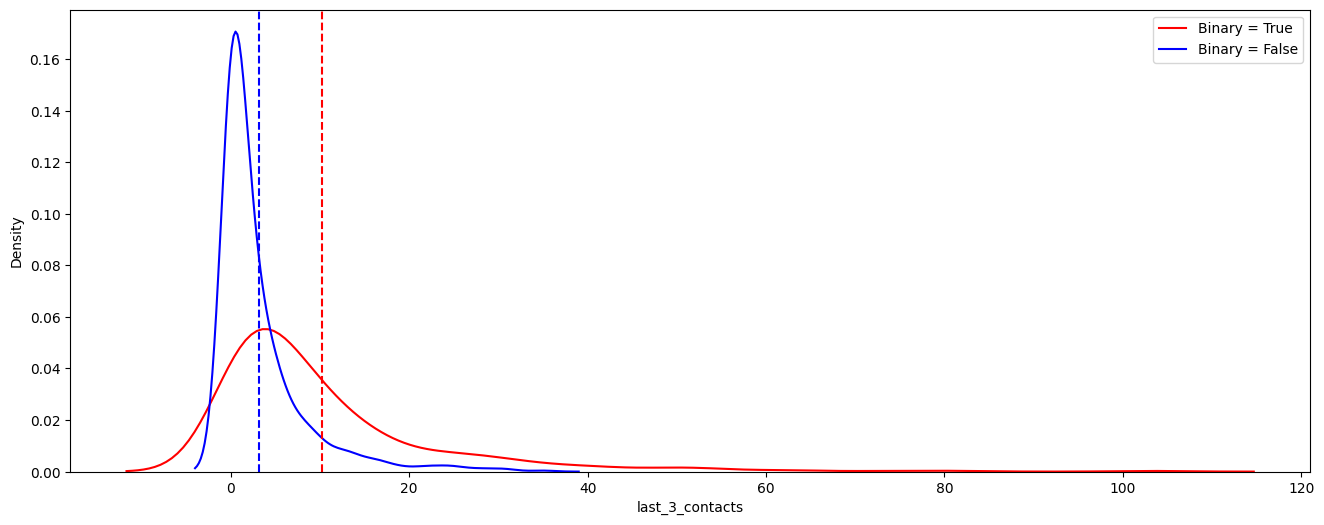

In [ ]:
find_cat_quant_correlation(quant_value = data['last_3_contacts'], binary_mask=data['is_bought']==1, plot = True, print_inference = True)

Mean quant value for group (binary=1) = 1.8951297997757153
Mean quant value for group (binary=0) = 0.9424162291583609
Median quant value for group (binary=1) = 1.9459101490553132
Median quant value for group (binary=0) = 0.6931471805599453
Kruskal-Wallis H Test p-value = 2.2215577772866467e-45
T-test p-value = 6.846453497217277e-52
point biserial correlation = 0.4189125444689098


{'point biserial R': 0.4189125444689098,
 'kruskal_pval': 2.2215577772866467e-45,
 'ttest_pval': 6.846453497217277e-52}

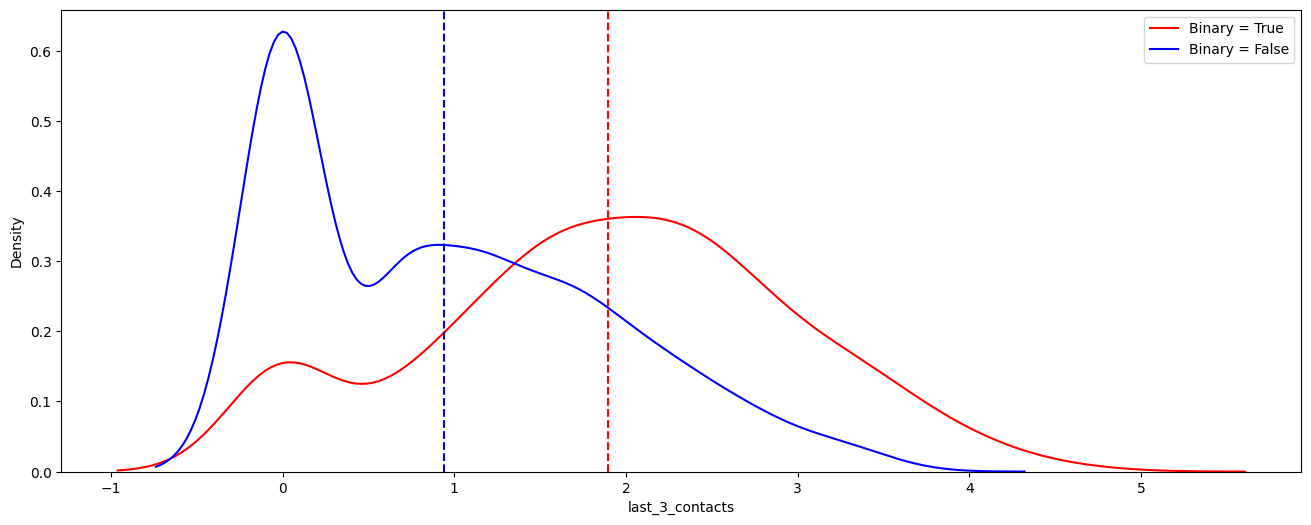

In [ ]:
find_cat_quant_correlation(quant_value = np.log(data['last_3_contacts']+1), binary_mask=data['is_bought']==1, plot = True, print_inference = True)

Как и следовало ожидать, у прологарифмированной метрики корреляция увеличилась на 0.056

## Логарифм last_3_views

Mean quant value for group (binary=1) = 335.90147783251234
Mean quant value for group (binary=0) = 138.25031766200763
Median quant value for group (binary=1) = 196.0
Median quant value for group (binary=0) = 73.0
Kruskal-Wallis H Test p-value = 1.7667452180529188e-35
T-test p-value = 3.231466116846216e-28
point biserial correlation = 0.3112803930747102


{'point biserial R': 0.3112803930747102,
 'kruskal_pval': 1.7667452180529188e-35,
 'ttest_pval': 3.231466116846216e-28}

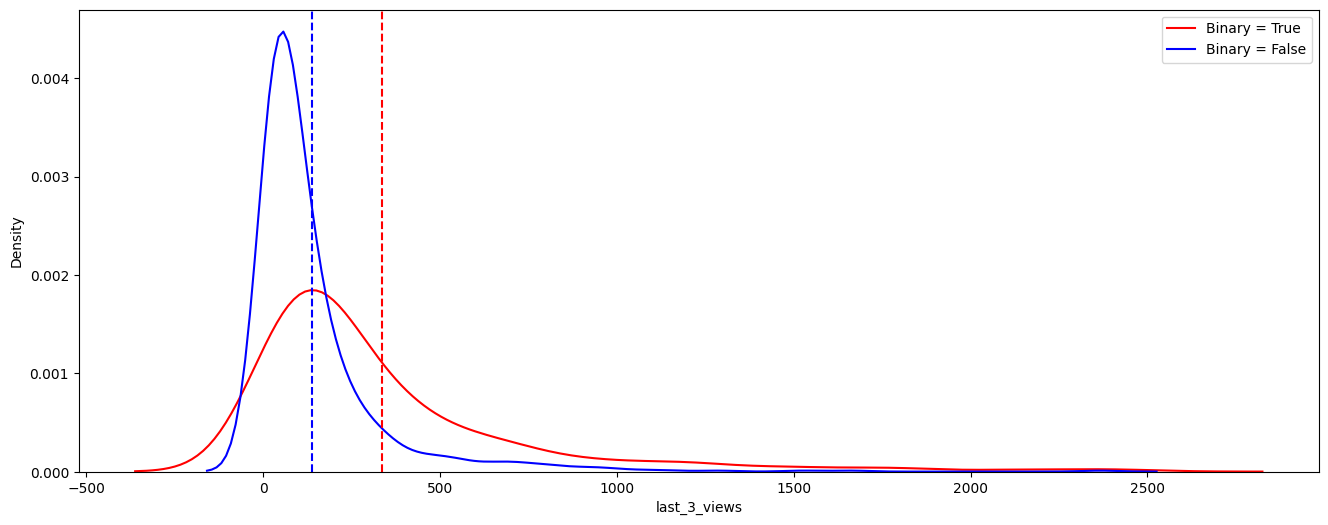

In [ ]:
find_cat_quant_correlation(quant_value = data['last_3_views'], binary_mask=data['is_bought']==1, plot = True, print_inference = True)

Mean quant value for group (binary=1) = 5.220161031670055
Mean quant value for group (binary=0) = 4.294882044350205
Median quant value for group (binary=1) = 5.283190844962526
Median quant value for group (binary=0) = 4.30406509320417
Kruskal-Wallis H Test p-value = 1.7667452180529188e-35
T-test p-value = 4.4951974177508544e-36
point biserial correlation = 0.35176836778116505


{'point biserial R': 0.35176836778116505,
 'kruskal_pval': 1.7667452180529188e-35,
 'ttest_pval': 4.4951974177508544e-36}

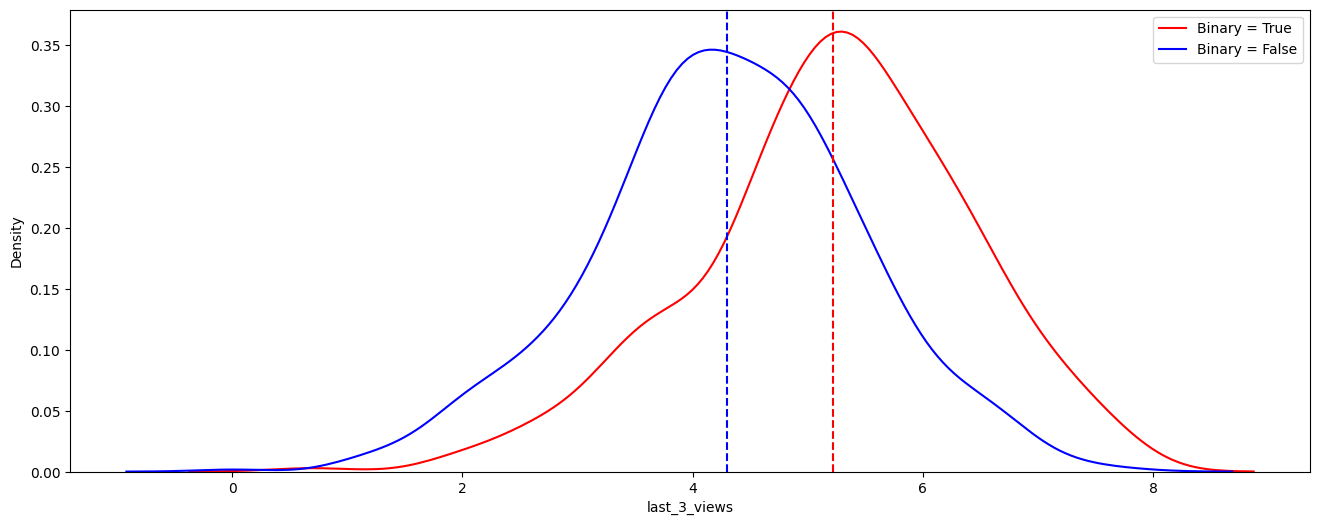

In [ ]:
find_cat_quant_correlation(quant_value = np.log(data['last_3_views']+1), binary_mask=data['is_bought']==1, plot = True, print_inference = True)

## last_3_contacts / last_3_views

Mean quant value for group (binary=1) = 0.3226600985221675
Mean quant value for group (binary=0) = 0.1588310038119441
Median quant value for group (binary=1) = 0.0
Median quant value for group (binary=0) = 0.0
Kruskal-Wallis H Test p-value = 3.566563459009145e-18
T-test p-value = 0.02786382139290139
point biserial correlation = 0.06367349881474367


{'point biserial R': 0.06367349881474367,
 'kruskal_pval': 3.566563459009145e-18,
 'ttest_pval': 0.02786382139290139}

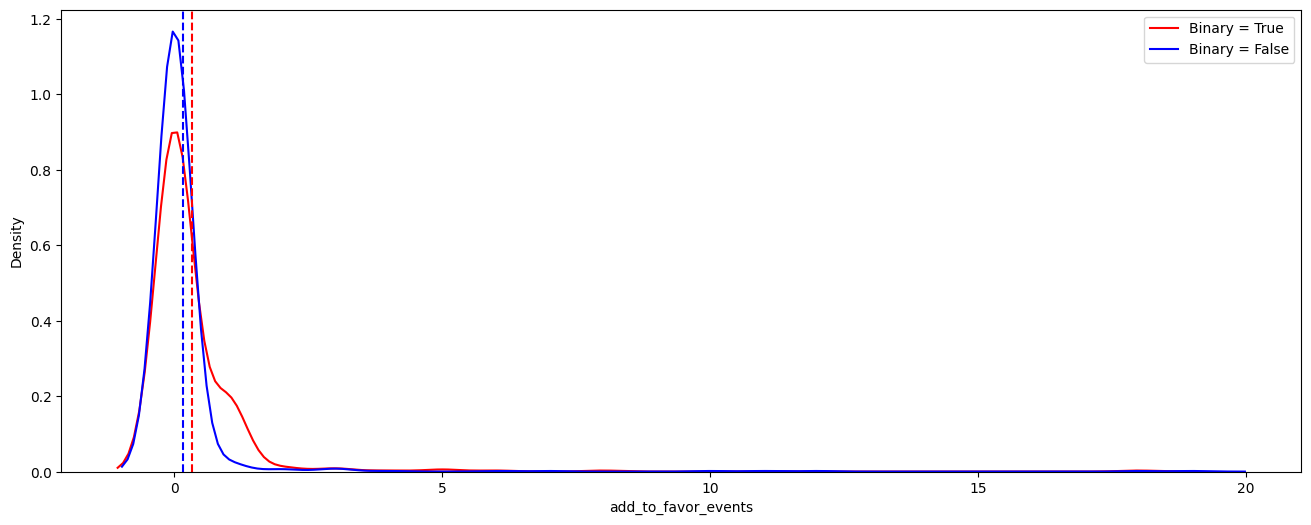

In [ ]:
find_cat_quant_correlation(quant_value = data['last_3_contacts']/(data['last_3_views']+1), binary_mask=data['is_bought']==1, plot = True, print_inference = True)

Mean quant value for group (binary=1) = 0.036729021527406765
Mean quant value for group (binary=0) = 0.026465915332858903
Median quant value for group (binary=1) = 0.02770398838163582
Median quant value for group (binary=0) = 0.012903404835907782
Kruskal-Wallis H Test p-value = 3.654464866764808e-18
T-test p-value = 1.9745153649299824e-05
point biserial correlation = 0.12321838039981119


{'point biserial R': 0.12321838039981119,
 'kruskal_pval': 3.654464866764808e-18,
 'ttest_pval': 1.9745153649299824e-05}

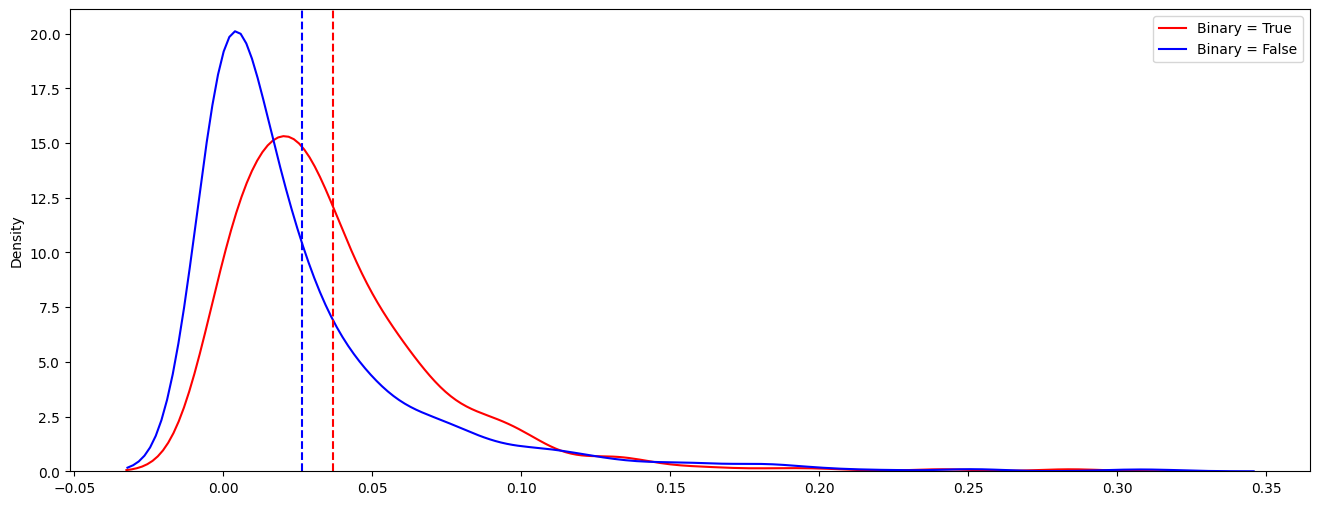

In [ ]:
find_cat_quant_correlation(quant_value = np.log(data['last_3_contacts']/(data['last_3_views']+1)+1), binary_mask=data['is_bought']==1, plot = True, print_inference = True)

В качестве лучших кандидатов на прокси-метрику стоит взять логарифмы last_3_contacts и last_3_views, т.к. у них самая высокая корреляция

|признак|корреляция|логарифм признака|корреляция|
|-|-|-|-|
|last_3_contacts| 0.36| log(last_3_contacts)|0.42|
|last_3_views|0.31|log(last_3_views)|0.35|
|last_3_contacts/last_3_views|0.12|log(last_3_contacts/last_3_views)|0.12|

# Поск порогов для прокси-метрики

## last_3_contacts

Как мы уже убедились раньше, погоги для исходной метрики соответствуют порогам той же пролагорифмированной метрики

Maximum Cramer V = 0.3672697346990414
Maximum Cramer V quant value =  3


{'max_cramer_v': 0.3672697346990414, 'max_corr_quant_value': 3}

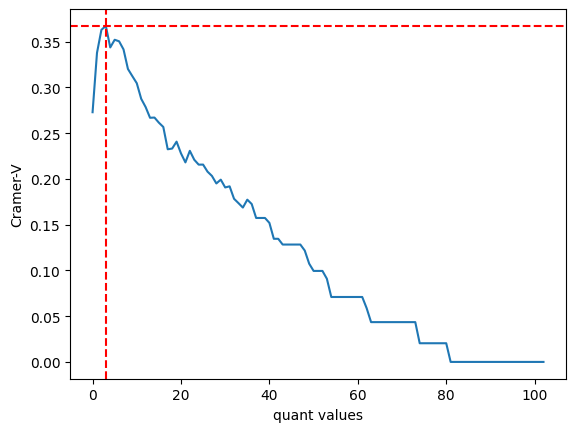

In [ ]:
max_cramerv_corr_finder(data['last_3_contacts'], data['is_bought']==1, plot = True, print_inference = True, step = 1)

## last_3_views

Maximum Cramer V = 0.3486475362928702
Maximum Cramer V quant value =  151


{'max_cramer_v': 0.3486475362928702, 'max_corr_quant_value': 151}

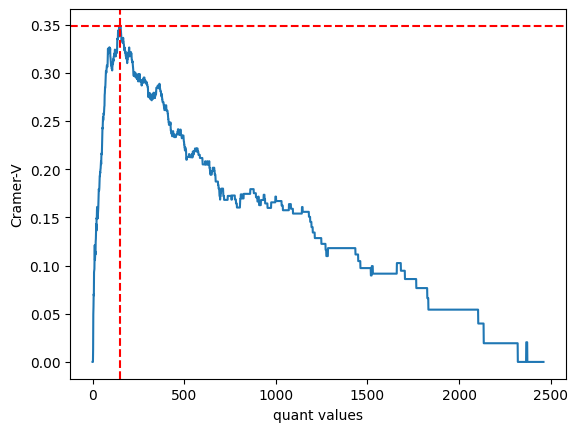

In [ ]:
max_cramerv_corr_finder(data['last_3_views'], data['is_bought']==1, plot = True, print_inference = True, step = 1)

# Проверим мощность прокси-метрики

Для оценки мощности будем использовать следующие вводные:

- проводим синтетические тесты на имеющихся исторических данных
- количество симуляций 10000
- размер добавляемого эффекта +10% к конверсии в тестовой группе для обоих типов теста (для основной метрики и для прокси-метрики)

## last_3_contacts

Рассчитаем мощность z-теста для исходной целевой метрики (доля тех, кто купил) и прокси-метрики (тех, у кого было больше 3-х контактов за три дня).

Ход симуляции:
1. С помощью маски на основе распределения Бернулли с вероятностью попадания в каждую группу 50% разбиваем данные с целевой метрикой (были продажи или нет - `is_bouth`) и значением для прокси-метрики (кол-во контактов за последние 3 дня, `last_3_contacts`) на тест и контроль.
2. Кол-во контактов за последние 3 дня преобразуем в бинарное значение с помощью сравнения с выбранным порогом - получаем прокси-метрику. Поскольку при определении порогового значения мы использовали условие ">" (в функции  `max_cramerv_corr_finder()`) , здесь мы также используем строгое неравенство.
3. Считаем кол-во успехов для целевой метрики и прокси-метрики и в тестовой, и в контрольной группе. К значению кол-ва успехов для обеих метрик в контрольной группе добавляем эффект.  
4. Проводим 2 z-теста на пропорцию для целевой метрики и прокси-метрики, проверяя гипотезу - есть ли статистически значимое отличие доли купивших/получивших свыше порогового значения контактов за последние 3 дня в тестовой и контрольной группе. Результаты теста (p-value) записываем в списки отдельно для целевой, отдельно для прокси-метрики.

После окончания цикла симуляций определяем долю экспериментов, в которых было получено статистически значимое различие в пропорции купивших/не купивших и превысивших пороговое кол-во контактов за 3 дня/не превысивших. Таким образом мы находим мощность эксперимента - в каком количестве экспериментов мы сможем детектировать эффект, при условии что он есть.

In [ ]:
#AB test simulation

ab_binary_ztest_pvalue_list = []
ab_quant_ztest_pvalue_list = []
quant_target_level = 3
abs_effect = 0.1
n_sim = 10000

for i in range(n_sim):
    sample_mask = ss.bernoulli.rvs(0.5, size=len(data)) == 1 # array([False, False,  True, ...,  True,  True,  True])

    binary_mask_group_a = (data['is_bought']==1)[sample_mask] # переводим is_bought в бинарные значения и отбираем по маске True (см пояснение 1)
    binary_mask_group_b = (data['is_bought']==1)[~sample_mask]
    quant_value_group_a = (data['last_3_contacts'])[sample_mask]
    quant_value_group_b = (data['last_3_contacts'])[~sample_mask]

    binary_nobs_group_a = len(binary_mask_group_a)
    binary_nobs_group_b = len(binary_mask_group_b)
    quant_nobs_group_a = len(quant_value_group_a)
    quant_nobs_group_b = len(quant_value_group_b)

    binary_counts_group_a = binary_mask_group_a.sum()
    binary_counts_group_b = round(binary_mask_group_b.sum()*(1+abs_effect)) #add effect
    quant_counts_group_a = (quant_value_group_a > quant_target_level).sum()
    quant_counts_group_b = round((quant_value_group_b > quant_target_level).sum()*(1+abs_effect)) #add effect

    binary_z_score_i, binary_ztest_pvalue_i = sms.proportions_ztest(count = [binary_counts_group_a, binary_counts_group_b],
                          nobs = [binary_nobs_group_a, binary_nobs_group_b])

    quant_z_score_i, quant_ztest_pvalue_i = sms.proportions_ztest(count = [quant_counts_group_a, quant_counts_group_b],
                          nobs = [quant_nobs_group_a, quant_nobs_group_b])

    ab_binary_ztest_pvalue_list.append(binary_ztest_pvalue_i)
    ab_quant_ztest_pvalue_list.append(quant_ztest_pvalue_i)

binary_power_ci = proportion_confint((np.array(ab_binary_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)
quant_power_ci = proportion_confint((np.array(ab_quant_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)

print('Effect =', abs_effect)
print('Sample size A group =', binary_nobs_group_a)
print('Sample size B group =', binary_nobs_group_b)

print('Target conversion A group = ', binary_counts_group_a / binary_nobs_group_a)
print('Target conversion B group = ', binary_counts_group_b / binary_nobs_group_b)
print('Proxy conversion A group = ', quant_counts_group_a / quant_nobs_group_a)
print('Proxy conversion B group = ', quant_counts_group_b / quant_nobs_group_b)

print('Мощность АБ-теста по целевой метрике', (np.array(ab_binary_ztest_pvalue_list) <= 0.05).sum() / n_sim)
print('99%-процентный доверительный интервал для мощности (доля продавших)', binary_power_ci)

print('Мощность АБ-теста по прокси метрике', (np.array(ab_quant_ztest_pvalue_list) <= 0.05).sum() / n_sim)
print('99%-процентный доверительный интервал для мощности (доля получивших больше 3-х контактов за последние 3 дня)', quant_power_ci)

Effect = 0.1
Sample size A group = 584
Sample size B group = 609
Target conversion A group =  0.3356164383561644
Target conversion B group =  0.3793103448275862
Proxy conversion A group =  0.410958904109589
Proxy conversion B group =  0.46798029556650245
Мощность АБ-теста по целевой метрике 0.2481
99%-процентный доверительный интервал для мощности (доля продавших) (0.23697473142371933, 0.25922526857628064)
Мощность АБ-теста по прокси метрике 0.3162
99%-процентный доверительный интервал для мощности (доля получивших больше 3-х контактов за последние 3 дня) (0.30422259980661454, 0.3281774001933854)


## last_3_views

Рассчитаем мощность z-теста для исходной целевой метрики (доля тех, кто купил) и прокси-метрики (тех, у кого было больше 151 просмотра за три дня) по такому же алгоритму, что и для last_3_contacts

In [ ]:
#AB test simulation

ab_binary_ztest_pvalue_list = []
ab_quant_ztest_pvalue_list = []
quant_target_level = 151
abs_effect = 0.1
n_sim = 10000

for i in range(n_sim):
    sample_mask = ss.bernoulli.rvs(0.5, size=len(data)) == 1 # array([False, False,  True, ...,  True,  True,  True])

    binary_mask_group_a = (data['is_bought']==1)[sample_mask] # переводим is_bought в бинарные значения и отбираем по маске True
    binary_mask_group_b = (data['is_bought']==1)[~sample_mask]
    quant_value_group_a = (data['last_3_views'])[sample_mask]
    quant_value_group_b = (data['last_3_views'])[~sample_mask]

    binary_nobs_group_a = len(binary_mask_group_a)
    binary_nobs_group_b = len(binary_mask_group_b)
    quant_nobs_group_a = len(quant_value_group_a)
    quant_nobs_group_b = len(quant_value_group_b)

    binary_counts_group_a = binary_mask_group_a.sum()
    binary_counts_group_b = round(binary_mask_group_b.sum()*(1+abs_effect)) #add effect
    quant_counts_group_a = (quant_value_group_a > quant_target_level).sum()
    quant_counts_group_b = round((quant_value_group_b > quant_target_level).sum()*(1+abs_effect)) #add effect

    binary_z_score_i, binary_ztest_pvalue_i = sms.proportions_ztest(count = [binary_counts_group_a, binary_counts_group_b],
                          nobs = [binary_nobs_group_a, binary_nobs_group_b])

    quant_z_score_i, quant_ztest_pvalue_i = sms.proportions_ztest(count = [quant_counts_group_a, quant_counts_group_b],
                          nobs = [quant_nobs_group_a, quant_nobs_group_b])

    ab_binary_ztest_pvalue_list.append(binary_ztest_pvalue_i)
    ab_quant_ztest_pvalue_list.append(quant_ztest_pvalue_i)

binary_power_ci = proportion_confint((np.array(ab_binary_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)
quant_power_ci = proportion_confint((np.array(ab_quant_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)

print('Effect =', abs_effect)
print('Sample size A group =', binary_nobs_group_a)
print('Sample size B group =', binary_nobs_group_b)

print('Target conversion A group = ', binary_counts_group_a / binary_nobs_group_a)
print('Target conversion B group = ', binary_counts_group_b / binary_nobs_group_b)
print('Proxy conversion A group = ', quant_counts_group_a / quant_nobs_group_a)
print('Proxy conversion B group = ', quant_counts_group_b / quant_nobs_group_b)

print('Мощность АБ-теста по целевой метрике', (np.array(ab_binary_ztest_pvalue_list) <= 0.05).sum() / n_sim)
print('99%-процентный доверительный интервал для мощности (доля продавших)', binary_power_ci)

print('Мощность АБ-теста по прокси метрике', (np.array(ab_quant_ztest_pvalue_list) <= 0.05).sum() / n_sim)
print('99%-процентный доверительный интервал для мощности (доля получивших больше 151 просмотров за последние 3 дня)', quant_power_ci)

Effect = 0.1
Sample size A group = 625
Sample size B group = 568
Target conversion A group =  0.3344
Target conversion B group =  0.38204225352112675
Proxy conversion A group =  0.3648
Proxy conversion B group =  0.4119718309859155
Мощность АБ-теста по целевой метрике 0.2434
99%-процентный доверительный интервал для мощности (доля продавших) (0.2323462271698204, 0.2544537728301796)
Мощность АБ-теста по прокси метрике 0.2676
99%-процентный доверительный интервал для мощности (доля получивших больше 151 просмотров за последние 3 дня) (0.2561966014837272, 0.2790033985162728)


# Выводы

1. Прокси-метрики **доля получивших больше 3-х контактов за последние 3 дня** и **доля получивших больше 151 просмотров за последние 3 дня** имеют большую мощность, по сравнению с целевой метрикой - доля продавших
2. Из выбранных прокси-метрик наилучшей по мощности является доля получивших больше 3-х контактов за последние 3 дня (что логично, поскольку событие "получение контактов" ближе к продаже, чем просмотры)
3. На следующем этапе необходимо подтвердить полученные выводы относительно возможности использования прокси-метрики на реальном A/B-тесте с нововведением, применив при этом дополнительный контроль за целевой метриков с помощью обзвонов

Примечание: стоит подумать, какие основания есть для того чтобы в симуляции добавлять эффект в одном и том же размере для целевой и прокси-метрики. Зависимость между этими переменными может иметь как линейный, так и не линейный характер, и стоило вместо корреляции восспользоваться хотя бы регрессией для оценки связи